# User defined variables

In [1]:
training_state_abbr = 'MN' # State USPS abbreviation
training_state_name = 'Minnesota' 
nas_id = 5 # European Frogbit = 1110; Eurasian watermilfoil = 237; Hydrilla verticillata = 6 (get these identifiers from https://nas.er.usgs.gov/api/v2/species)
nas_name = 'ZM'
# IA = 19; ID = 16; IL = 17; MN = 27; MO = 29; MT = 30; OR = 41;  WA = 53; WI = 55
training_fip = 27
# Replace last 2 digits with your state's FIP code
training_path = 'my_data/' + training_state_abbr + '_ch3/' # leave this alone 
my_crs = "EPSG:5070"

In [2]:
'''
This version allows you to create predictors for in-state models where an AIS exist as well as a second set of predictors for 
predicting to your state if your AIS is not present. You only need to make the training predictors if you are training and predicting 
to the same state.  To predict to a different state you need to make predictors for that state too.
'''
#Import required Python packages. 
'''
If you get an error here, search for the package name online + conda installation; open a new Anaconda PowerShell window;
activate your environment and paste in the code you found online into the prompt.  It will most likely be: pip install "package-name" 
for Python packages or conda install conda-forge:: "package-name" for cross-platform packages (i.e., Scikit Learn).  
'''

import os
import json
import glob
import zipfile
import random
import io
from io import StringIO, BytesIO
from tqdm import tqdm
import time
# Data Handling
import pandas as pd
import numpy as np
import geopandas as gpd
from typing import Set, Tuple
import rasterio
from rasterio.transform import from_origin
from rasterio.features import rasterize
from rasterio.mask import mask
import rasterio.plot
from rasterio.warp import calculate_default_transform, reproject, Resampling
from affine import Affine
import networkx as nx
from shapely.geometry import Point, LineString, MultiLineString, MultiPoint
from shapely.ops import snap, nearest_points
from rasterio.transform import from_bounds
from shapely.geometry import box
from shapely.ops import unary_union
from rasterio.merge import merge
from rasterio.errors import RasterioIOError
from joblib import Parallel, delayed
# Machine Learning & Statistical Modeling
import sklearn as skl
from sklearn.neighbors import KDTree, KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn import gaussian_process

# Geostatistics & Interpolation
import skgstat as skg
import gstools as gs
from skgstat import models
from skgstat.util.likelihood import get_likelihood
import scipy
from scipy.spatial.distance import pdist
from scipy.spatial import distance_matrix
from scipy.optimize import minimize
from scipy.spatial import cKDTree
from shapely.strtree import STRtree
from scipy.interpolate import NearestNDInterpolator
import scipy.ndimage
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging

# Visualization
import matplotlib.pyplot as plt

# APIs & Requests
import requests
from pygbif import occurrences as occ
from pygbif import species
from shapely import union_all

from joblib import Parallel, delayed
from contextlib import contextmanager
import joblib
from collections import defaultdict
from functools import partial
from multiprocessing import Manager, Lock
import tempfile
from shapely.geometry import CAP_STYLE
from shapely.ops import unary_union, polygonize

#Import required GBIF packages
from pygbif import occurrences as occ 
from pygbif import species

In [3]:
# Water quality helper functions
def get_usgs_stations_in_state(state_fip, state_abbr, my_path):
    """
    Downloads USGS water monitoring station data and filters it to the specified state boundary.

    Parameters:
    - state_fip (str): State FIPS code in the form 'US:55'
    - state_abbr (str): Two-letter state abbreviation (e.g., 'WI')
    - my_path (str): Directory to save shapefile (must end with '/')

    Returns:
    - GeoDataFrame: Filtered monitoring stations within the state
    """
    # === Step 1: Download USGS station data ===
    print("📥 Downloading USGS station data...")
    url_base = 'https://www.waterqualitydata.us/data/Station/search?'
    request_url = f"{url_base}countrycode=US&statecode=US:{state_fip}"
    station_df = pd.read_csv(request_url)

    stations = station_df[['MonitoringLocationIdentifier', 'LatitudeMeasure', 'LongitudeMeasure']].rename(columns={
        'MonitoringLocationIdentifier': 'station_id',
        'LatitudeMeasure': 'latitude',
        'LongitudeMeasure': 'longitude'
    })

    stations_gdf = gpd.GeoDataFrame(
        stations,
        geometry=gpd.points_from_xy(stations.longitude, stations.latitude),
        crs="EPSG:4326"
    ).to_crs("EPSG:5070")

    # === Step 2: Download state boundaries shapefile ===
    print("🗺️  Downloading state boundary shapefile...")
    state_boundary_url = 'http://www2.census.gov/geo/tiger/TIGER2012/STATE/tl_2012_us_state.zip'
    r = requests.get(state_boundary_url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(path=my_path)
    
    # Load shapefile
    shp_path = os.path.join(my_path, [f for f in z.namelist() if f.endswith('.shp')][0])
    state_boundary = gpd.read_file(shp_path).to_crs("EPSG:5070")

    # === Step 3: Filter to selected state ===
    state = state_boundary[state_boundary['STUSPS'] == state_abbr]
    if state.empty:
        raise ValueError(f"No state found for abbreviation '{state_abbr}'")

    # Match CRS and filter points within state
    stations_gdf = stations_gdf.to_crs(state.crs)
    filtered_stations = gpd.sjoin(
        stations_gdf, state, how="inner", predicate="within"
    ).drop(columns=["index_right"])

    # === Step 4: Save to file and return ===
    out_file = os.path.join(my_path, f"usgs_stations_{state_abbr}.shp")
    filtered_stations.to_file(out_file)
    print(f"✅ Filtered station shapefile saved to: {out_file}")

    return filtered_stations



def find_nearest(row, other_gdf):
    # Find the index of the nearest geometry
    nearest_idx = other_gdf.distance(row.geometry).idxmin()
    return other_gdf.loc[nearest_idx]
def add_nearest(gdf1, gdf2):
    nearest_neighbors = gdf1.apply(lambda row: find_nearest(row, gdf2), axis=1)
    # Add nearest neighbor information to the first GeoDataFrame
    gdf1['nearest_id'] = nearest_neighbors['station_id']
    gdf1['median'] = nearest_neighbors['median']
    parameter_added = gdf1
    return parameter_added
def thin_geodataframe(gdf, min_dist=100):
    """
    Spatially thin a GeoDataFrame using a minimum distance (in meters).
    Ensures points are at least `min_dist` apart.
    """
    if gdf.crs.to_epsg() != 5070:
        gdf = gdf.to_crs("EPSG:5070")

    # Create mapping from geometry to index
    geom_to_index = {id(geom): idx for idx, geom in zip(gdf.index, gdf.geometry)}
    strtree = STRtree(gdf.geometry.values)

    kept_geoms = []
    taken_ids = set()

    for geom in gdf.geometry:
        if id(geom) in taken_ids:
            continue

        kept_geoms.append(geom)
        buffered = geom.buffer(min_dist)
        for neighbor in strtree.query(buffered):
            taken_ids.add(id(neighbor))

    return gpd.GeoDataFrame(geometry=kept_geoms, crs=gdf.crs)

# Data acquisition & formating
def download_wqp_csv(url, max_retries=3, backoff=5):
    for attempt in range(max_retries):
        try:
            with requests.get(url, stream=True, timeout=60) as r:
                r.raise_for_status()
                content = r.content  # read all bytes
            return io.BytesIO(content)
        except (requests.exceptions.RequestException, requests.exceptions.ChunkedEncodingError) as e:
            print(f"Download failed (attempt {attempt+1}/{max_retries}): {e}")
            if attempt < max_retries - 1:
                print(f"Retrying in {backoff} seconds...")
                time.sleep(backoff)
            else:
                raise



def get_water_quality(characteristic, state_fip, stations_gdf, my_path):
    """
    Download, clean, summarize, and spatially join water quality data from WQP.

    Parameters:
    - characteristic (str): Water quality variable (e.g., 'pH', 'Calcium', 'Nitrogen', 'Phosphorus', 'Oxygen', 'Salinity', 'Temperature, water')
    - state_fip (str): State FIPS code (e.g., '55' for Wisconsin)
    - stations_gdf (GeoDataFrame): Monitoring stations to match to data
    - my_path (str): Path to save output shapefile (include trailing slash)

    Returns:
    - GeoDataFrame: Stations with median value for the specified characteristic
    """
    import os
    import pandas as pd
    
    # === Step 1: Download data ===
    print(f"📥 Downloading {characteristic} data from WQP...")
    url_base = 'https://www.waterqualitydata.us/data/Result/search?'
    request_url = f"{url_base}countrycode=US&statecode=US:{state_fip}&characteristicName={characteristic}&mimeType=csv"
    csv_buffer = download_wqp_csv(request_url)
    df = pd.read_csv(csv_buffer)
    print(f"✅ Retrieved {len(df)} records")

    # === Step 2: Clean and rename ===
    df = df.dropna(subset=['ResultMeasureValue'])
    df['ResultMeasureValue'] = pd.to_numeric(df['ResultMeasureValue'], errors='coerce')
    
    df_clean = df[['CharacteristicName', 'ActivityStartDate', 'MonitoringLocationIdentifier',
                   'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode']].rename(columns={
        "CharacteristicName": "Characteristic",
        "ActivityStartDate": "date",
        "MonitoringLocationIdentifier": "station_id",
        "ResultMeasureValue": "value",
        "ResultMeasure/MeasureUnitCode": "unit"
    })

    # === Step 3: Standardize units ===
    df_clean['unit'] = df_clean['unit'].astype(str).str.strip().str.lower()

    char_lower = characteristic.lower()
    # Process Calcium, Nitrogen, Phosphorus as before
    if char_lower in ['calcium', 'nitrogen', 'phosphorus']:
        df_clean.loc[df_clean['unit'].isin(['ug/l', 'ppb', 'mg/g']), 'value'] /= 1000
        df_clean['unit'] = df_clean['unit'].replace({
            'mg/l': 'mg/l', 'mg/l as p': 'mg/l', 'mg/l po4': 'mg/l',
            'mg/kg': 'mg/l', 'mg/kg as p': 'mg/l',
            'ug/l': 'mg/l', 'ppb': 'mg/l', 'mg/g': 'mg/l'
        })

    elif char_lower == 'ph':
        df_clean = df_clean[(df_clean['unit'].isna()) | (df_clean['unit'].isin(['std units', '', 'na']))]
        df_clean['unit'] = 'std units'

    elif char_lower == 'oxygen':
        # Convert mg/L oxygen to % saturation using multiplier 12.67 (approximate)
        df_clean.loc[df_clean['unit'] == 'mg/l', 'value'] *= 12.67
        df_clean['unit'] = df_clean['unit'].replace({'mg/l': '% saturatn', '% by vol': '% saturatn'})

    elif char_lower == 'salinity':
        # Convert salinity to PSU (practical salinity units)
        # Common units include ppt, PSU, mg/L (rare, then convert to ppt)
        # 1 ppt ≈ 1 PSU
        # Convert mg/L to ppt by dividing by 1000 (assuming 1 ppt = 1000 mg/L)
        # For simplicity, unify all to 'ppt'
        # Handle common unit variants
        def convert_salinity(row):
            u = row['unit']
            v = row['value']
            if u in ['psu', 'ppt', 'parts per thousand', '‰']:
                return v
            elif u in ['mg/l', 'mg/l as cl', 'mg/l as nacl']:
                return v / 1000  # convert mg/L to ppt approx
            elif u in ['g/l']:
                return v * 1000  # g/L to ppt (1000 ppt per g/L)
            else:
                # unknown units, keep as is but warn
                return v

        df_clean['value'] = df_clean.apply(convert_salinity, axis=1)
        df_clean['unit'] = 'ppt'

    elif char_lower == 'temperature, water':
        # Convert temperature to Celsius if needed
        def convert_temp(row):
            u = row['unit']
            v = row['value']
            if u in ['c', 'deg c', '°c', 'celsius']:
                return v
            elif u in ['f', 'deg f', '°f', 'fahrenheit']:
                return (v - 32) * 5.0 / 9.0
            elif u in ['k', 'kelvin']:
                return v - 273.15
            else:
                # unknown units, keep as is but warn
                return v

        df_clean['value'] = df_clean.apply(convert_temp, axis=1)
        df_clean['unit'] = 'c'

    # === Step 4: Filter implausible values ===
    if char_lower == 'calcium':
        df_clean = df_clean[(df_clean['unit'] == 'mg/l') & (df_clean['value'].between(0, 300))]
    elif char_lower == 'ph':
        df_clean = df_clean[(df_clean['value'].between(4, 14))]
    elif char_lower == 'nitrogen':
        df_clean = df_clean[(df_clean['unit'] == 'mg/l') & (df_clean['value'].between(0, 500))]
    elif char_lower == 'phosphorus':
        df_clean = df_clean[(df_clean['unit'] == 'mg/l') & (df_clean['value'].between(0, 1))]
    elif char_lower == 'oxygen':
        df_clean = df_clean[(df_clean['unit'] == '% saturatn') & (df_clean['value'].between(0, 200))]
    elif char_lower == 'salinity':
        # plausible range for salinity in ppt (freshwater to ocean)
        df_clean = df_clean[(df_clean['unit'] == 'ppt') & (df_clean['value'].between(0, 42))]
    elif char_lower == 'temperature, water':
        # plausible range in Celsius (e.g., -5 to 40 C)
        df_clean = df_clean[(df_clean['unit'] == 'c') & (df_clean['value'].between(-5, 40))]

    # === Step 5: Aggregate by station ===
    summary = df_clean.groupby('station_id')['value'].median().reset_index()
    summary.rename(columns={'value': 'median'}, inplace=True)

    # === Step 6: Spatial join with training stations ===
    stations_with = pd.merge(stations_gdf, summary, on='station_id', how='inner')
    stations_missing = stations_gdf[~stations_gdf['station_id'].isin(stations_with['station_id'])]

    # === Step 7: Fill missing via nearest station ===
    print(f"🔄 Imputing missing {characteristic} values...")
    stations_filled = add_nearest(stations_missing, stations_with)
    final_gdf = pd.concat([stations_with, stations_filled], axis=0).drop(columns=["nearest_id", "latitude", "longitude"], errors='ignore')

    # === Step 8: Save shapefile ===
    out_name = f"usgs_{characteristic.lower().replace(' ', '_').replace(',', '').replace('-', '_')}.shp"
    out_path = os.path.join(my_path, out_name)
    final_gdf.to_file(out_path)
    print(f"✅ {characteristic} data saved to: {out_path}")

    return final_gdf


# Functions for making predictors
def interpolate(stations_w_data, filename, bandname="Interpolated_Band", pixel_size=100, use_kriging='auto'):
    # Ensure CRS and extract coordinates
    stations_w_data = stations_w_data.copy()
    stations_w_data = stations_w_data.set_crs("EPSG:5070")
    stations_w_data['x'] = stations_w_data.geometry.x
    stations_w_data['y'] = stations_w_data.geometry.y
    samples_df = stations_w_data[['x', 'y', 'median']]
    coords = np.column_stack((samples_df['x'], samples_df['y']))
    vals = samples_df['median']

    # Scatter plot
    fig, ax = plt.subplots(figsize=(10, 10))
    art = ax.scatter(samples_df['x'], samples_df['y'], s=10, c=vals, cmap='plasma', vmin=0, vmax=vals.max())
    plt.colorbar(art)
    plt.title("Original Data Points")
    plt.show()

    # Define bounds and grid size
    xmin, xmax = samples_df['x'].min(), samples_df['x'].max()
    ymin, ymax = samples_df['y'].min(), samples_df['y'].max()

    # Define grid size based on pixel resolution
    ncols = int(np.ceil((xmax - xmin) / pixel_size))
    nrows = int(np.ceil((ymax - ymin) / pixel_size))
    xres = pixel_size
    yres = pixel_size
    
    print(f"📏 Pixel size: {xres} m x {yres} m")
    print(f"📦 Grid dimensions: {ncols} cols × {nrows} rows")
    
    # Smart fallback if 'auto' is used
    if use_kriging == 'auto':
        use_kriging = (ncols * nrows <= 1e6)
    
    # Interpolation block
    if use_kriging:
        try:
            print("🔹 Attempting Ordinary Kriging interpolation...")
            maxlag = np.median(pdist(coords))
            n_lags = min(30, max(10, int(len(coords) / 10)))
            V = skg.Variogram(coords, vals, model='exponential', maxlag=maxlag, n_lags=n_lags, normalize=False)
            ok = skg.OrdinaryKriging(V, min_points=1, max_points=8, mode='exact')
    
            grid_x = np.linspace(xmin, xmax, ncols)
            grid_y = np.linspace(ymin, ymax, nrows)
            xx, yy = np.meshgrid(grid_x, grid_y)
    
            field = ok.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)
            print("✅ Kriging completed successfully.")
    
        except (MemoryError, ValueError, np.linalg.LinAlgError):
            print("⚠️ Kriging failed, switching to Nearest Neighbor interpolation...")
            use_kriging = False  # Fallback to KNN
    else:
        print("⚠️ Skipping Kriging; using Nearest Neighbor interpolation...")
    
    # KNN Interpolation (used either by default or after Kriging fails)
    if not use_kriging:
        grid_x = np.linspace(xmin, xmax, ncols)
        grid_y = np.linspace(ymin, ymax, nrows)
        xx, yy = np.meshgrid(grid_x, grid_y)
    
        knn = KNeighborsRegressor(n_neighbors=min(8, len(coords)), weights='distance', algorithm='kd_tree', n_jobs=-1)
        knn.fit(coords, vals)
        query_points = np.column_stack((xx.ravel(), yy.ravel()))
        field = knn.predict(query_points).reshape(xx.shape)
    
        print("✅ Nearest Neighbor interpolation completed.")


    # Fill NaNs
    def fill_missing_values(field):
        mask = np.isnan(field)
        if np.all(mask):
            raise ValueError("All values are NaN; interpolation cannot be performed.")
        nearest_indices = scipy.ndimage.distance_transform_edt(mask, return_distances=False, return_indices=True)
        field[mask] = field[tuple(nearest_indices[i][mask] for i in range(field.ndim))]
        return field

    field = fill_missing_values(field)

    # Prepare raster
    arr = np.flip(field, axis=0).astype(np.float32)
    transform = from_origin(xmin, ymax, xres, yres)

    with rasterio.open(filename, 'w', driver='GTiff',
                       height=arr.shape[0], width=arr.shape[1],
                       count=1, dtype=arr.dtype,
                       crs="EPSG:5070", transform=transform) as dst:
        dst.write(arr, 1)
        dst.set_band_description(1, bandname)

    print(f"✅ Raster saved: {filename}")

    # Plot final raster
    plt.figure(figsize=(10, 8))
    plt.imshow(arr, extent=[xmin, xmax, ymin, ymax], cmap='plasma', origin="upper")
    plt.colorbar(label=bandname)
    plt.title("Interpolated Raster")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.show()



def combine_geotiffs(input_files, output_file):
    """
    Combine single- or multi-band GeoTIFFs into one multi-band GeoTIFF,
    preserving band names where available.

    Parameters:
        input_files (list): List of input raster file paths.
        output_file (str): Path to output multi-band GeoTIFF.
        state (str): Optional metadata tag (not used in core logic).
    """
    all_bands = []
    band_descriptions = []
    meta = None

    for file in input_files:
        try:
            with rasterio.open(file) as src:
                if meta is None:
                    meta = src.meta.copy()
                    meta.update({
                        'count': 0,  # Will be updated after reading all bands
                        'dtype': src.dtypes[0]  # Assumes consistent dtype
                    })

                for bidx in range(1, src.count + 1):
                    band_data = src.read(bidx)
                    all_bands.append(band_data)

                    # Try to get band description (e.g., band name)
                    desc = src.descriptions[bidx - 1] or f'band_{bidx}'
                    band_descriptions.append(desc)

        except RasterioIOError:
            print(f"⚠️ Warning: Could not read {file}, skipping...")

    if not all_bands:
        raise RuntimeError("❌ No valid input rasters found.")

    meta['count'] = len(all_bands)

    with rasterio.open(output_file, 'w', **meta) as dst:
        for idx, band in enumerate(all_bands, start=1):
            dst.write(band, idx)
            if band_descriptions[idx - 1]:
                dst.set_band_description(idx, band_descriptions[idx - 1])






"""
⚠️  Note on Warnings:
Some warnings may appear during this script. These warnings do not indicate pipeline failure and can be safely ignored unless followed by an error.
"""

# Start of Water Quality predictors

In [4]:
training_stations_gdf = get_usgs_stations_in_state(
    state_fip= training_fip,      
    state_abbr= training_state_abbr,
    my_path= training_path
)

📥 Downloading USGS station data...


C:\Users\leif.howard\AppData\Local\Temp\ipykernel_11200\1878486312.py:18: DtypeWarning: Columns (5,8,10,14,15,21,27,28,29,30,31,33) have mixed types. Specify dtype option on import or set low_memory=False.
  station_df = pd.read_csv(request_url)


🗺️  Downloading state boundary shapefile...
✅ Filtered station shapefile saved to: my_data/MN_ch3/usgs_stations_MN.shp


In [ ]:
# Calcium
training_ca = get_water_quality("Calcium", state_fip=training_fip, stations_gdf=training_stations_gdf, my_path=training_path)

In [ ]:
# pH
training_pH= get_water_quality("pH", state_fip=training_fip, stations_gdf=training_stations_gdf, my_path=training_path)

In [ ]:
# Dissolved Oxygen
training_DO = get_water_quality('Oxygen', state_fip=training_fip, stations_gdf=training_stations_gdf, my_path=training_path)

In [ ]:
# Nitrogen
training_N = get_water_quality("Nitrogen", state_fip=training_fip, stations_gdf=training_stations_gdf, my_path=training_path)

In [ ]:
# Phosphorus
training_Phos = get_water_quality("Phosphorus", state_fip=training_fip, stations_gdf=training_stations_gdf, my_path=training_path)

In [ ]:
# Salinity
training_Salinity = get_water_quality('Salinity', state_fip=training_fip, stations_gdf=training_stations_gdf, my_path=training_path)

In [ ]:
# Water Temperature
training_Temp = get_water_quality('Temperature', state_fip=training_fip, stations_gdf=training_stations_gdf, my_path=training_path)

In [ ]:
interpolate(training_ca, training_path + training_state_abbr + '_ca.tif', 'Ca')

In [ ]:
interpolate(training_pH, training_path + training_state_abbr + '_pH.tif', 'pH')

In [ ]:
interpolate(training_N, training_path + training_state_abbr + '_N.tif', 'Nitrogen')

In [ ]:
interpolate(training_DO, training_path + training_state_abbr + '_do.tif', 'DO')

In [ ]:
interpolate(training_Phos, training_path + training_state_abbr + '_phos.tif', 'Phos')

In [ ]:
interpolate(training_Salinity, training_path + training_state_abbr + '_salinity.tif', 'Salinity')

In [ ]:
interpolate(training_Temp, training_path + training_state_abbr + '_temp.tif', 'Temperature')

In [ ]:
# Combine all the predictors you just created and export a final combined raster 
# Define input files
input_files_wq_training = [
    training_path + training_state_abbr + "_ca.tif", training_path + training_state_abbr + "_pH.tif", training_path + training_state_abbr + "_N.tif",
    training_path + training_state_abbr + "_do.tif", training_path + training_state_abbr + "_phos.tif"]
#Combine rasters into a multi-band GeoTIFF
output_file_wq_training = training_path + training_state_abbr + "_combined_wq.tif" # this will replace the other combined tif you made.
combine_geotiffs(input_files_wq_training, output_file_wq_training)

print(f"✅ Multi-band raster saved as {output_file_wq_training}")


In [27]:
def get_nhd_waterbodies(state_name, local_path, output_prefix=None, save_files=True,
                         make_background_water=False, training_path=None, training_state_abbr=None):
    """
    Downloads, extracts, and loads NHD shapefiles for a U.S. state, returning lakes, rivers, and flowlines.
    """
    if output_prefix is None:
        output_prefix = state_name.lower()

    os.makedirs(local_path, exist_ok=True)

    # Use GPKG filepaths for caching
    lakes_gpkg = os.path.join(local_path, f"{output_prefix}_lakes.gpkg")
    rivers_gpkg = os.path.join(local_path, f"{output_prefix}_rivers.gpkg")
    streams_gpkg = os.path.join(local_path, f"{output_prefix}_streams.gpkg")

    if save_files and all(os.path.exists(f) for f in [lakes_gpkg, rivers_gpkg, streams_gpkg]):
        print("📂 Found existing GPKG files. Loading from disk...")
        lakes = gpd.read_file(lakes_gpkg)
        rivers = gpd.read_file(rivers_gpkg)
        streams = gpd.read_file(streams_gpkg)
    else:
        # === Step 1–5: Download, extract, load ===
        url = f"https://prd-tnm.s3.amazonaws.com/StagedProducts/Hydrography/NHD/State/Shape/NHD_H_{state_name}_State_Shape.zip"
        print(f"📥 Downloading NHD data for {state_name}...")
        response = requests.get(url, stream=True)
        if response.status_code != 200:
            raise Exception(f"❌ Failed to download NHD data for {state_name}")

        with tempfile.NamedTemporaryFile(delete=False, suffix=".zip") as tmp_file:
            for chunk in response.iter_content(chunk_size=8192):
                tmp_file.write(chunk)

        with zipfile.ZipFile(tmp_file.name, 'r') as z:
            z.extractall(path=local_path)
        print("✅ Extraction complete.")

        shp_files = glob.glob(os.path.join(local_path, "**", "*.shp"), recursive=True)
        if not shp_files:
            raise FileNotFoundError("❌ No shapefiles found in extracted directory.")

        lakes_path = next((f for f in shp_files if "nhdwaterbody" in f.lower()), None)
        if not lakes_path:
            raise FileNotFoundError("❌ No NHDWaterbody shapefile found.")
        lakes = gpd.read_file(lakes_path)

        rivers_path = next((f for f in shp_files if "nhdarea" in f.lower()), None)
        if not rivers_path:
            raise FileNotFoundError("❌ No NHDArea shapefile found.")
        rivers = gpd.read_file(rivers_path)

        print("📄 Loading and combining stream flowlines...")
        flowline_paths = [f for f in shp_files if "nhdflowline" in f.lower()]
        if not flowline_paths:
            raise FileNotFoundError("❌ No NHDFlowline shapefiles found.")
        stream_dfs = [gpd.read_file(fp) for fp in flowline_paths]
        streams = gpd.GeoDataFrame(pd.concat(stream_dfs, ignore_index=True), crs=stream_dfs[0].crs)

        if save_files:
            print("💾 Saving as GeoPackage files...")
            lakes.to_file(lakes_gpkg, driver="GPKG")
            rivers.to_file(rivers_gpkg, driver="GPKG")
            streams.to_file(streams_gpkg, driver="GPKG")

    # ✅ Now return regardless of source (cached or new)
    result = {
        "lakes": lakes,
        "rivers": rivers,
        "streams": streams
    }

    if make_background_water and training_path and training_state_abbr:
        bg_water = pd.concat([lakes, rivers], ignore_index=True)
        output_file = os.path.join(training_path, f"{training_state_abbr}_bg_water.shp")
        bg_water.to_file(output_file)
        result["bg_water"] = bg_water

    return result


def buffer_water_layers(
    streams: gpd.GeoDataFrame = None,
    lakes: gpd.GeoDataFrame = None,
    rivers: gpd.GeoDataFrame = None,
    simplify_tolerance: float = None,
    filter_streams: bool = True,
    save_path: str = None,
    use_cached: bool = True,
    export_merged_filename: str = None
) -> tuple[gpd.GeoDataFrame, gpd.GeoDataFrame, gpd.GeoDataFrame, gpd.GeoDataFrame, gpd.GeoDataFrame]:
    """
    Buffer and merge water layers, optionally using cached files.
    """

    crs = "EPSG:5070"

    # Define cache paths
    if save_path:
        os.makedirs(save_path, exist_ok=True)
        stream_file = os.path.join(save_path, "buffered_streams.gpkg")
        lake_file = os.path.join(save_path, "buffered_lakes.gpkg")
        river_file = os.path.join(save_path, "buffered_rivers.gpkg")
        full_stream_file = os.path.join(save_path, "full_streams.shp")

        cache_exists = all(os.path.exists(f) for f in [stream_file, lake_file, river_file, full_stream_file])
        if use_cached and cache_exists:
            print("📂 Loading buffered layers from cache...")
            buffered_streams = gpd.read_file(stream_file)
            buffered_lakes = gpd.read_file(lake_file)
            buffered_rivers = gpd.read_file(river_file)
            full_streams = gpd.read_file(full_stream_file)

            buffered_water = pd.concat([buffered_streams, buffered_lakes, buffered_rivers], ignore_index=True)
            buffered_water = buffered_water[buffered_water.geometry.notnull()]
            buffered_water["waterID"] = range(1, len(buffered_water) + 1)

            if export_merged_filename and not os.path.exists(export_merged_filename):
                print(f"💾 Merging and exporting combined buffered layer to {export_merged_filename}...")
                buffered_water.to_file(export_merged_filename)

            return buffered_streams, buffered_lakes, buffered_rivers, full_streams, buffered_water

    # If no cache or not using cache, we require streams/lakes/rivers
    if streams is None or lakes is None or rivers is None:
        raise ValueError("streams, lakes, and rivers must be provided if not using cached files.")

    # === Process from scratch ===
    print("[1/6] Projecting all layers...")
    streams = streams.to_crs(crs)
    lakes = lakes.to_crs(crs)
    rivers = rivers.to_crs(crs)
    full_streams = streams.copy()

    print("[2/6] Filtering lakes and rivers with areasqkm ≥ 0.25...")
    lakes = lakes[lakes.is_valid & lakes.geometry.notnull() & (lakes["areasqkm"] >= 0.25)]
    rivers = rivers[rivers.is_valid & rivers.geometry.notnull() & (rivers["areasqkm"] >= 0.25)]

    print("[3/6] Preparing stream geometry...")
    # Drop invalid or missing geometries before simplification
    filtered_streams = streams.copy()
    filtered_streams = filtered_streams[filtered_streams.geometry.notnull()].copy()
    filtered_streams = filtered_streams[filtered_streams.is_valid].copy()
    
    # Now apply simplification
    if simplify_tolerance is not None:
        print(f"[4/6] Simplifying stream geometries with tolerance {simplify_tolerance}...")
        filtered_streams["geometry"] = filtered_streams.geometry.simplify(
            tolerance=simplify_tolerance, preserve_topology=True)
    else:
        print("[4/6] Skipping simplification.")

    print("[5/6] Buffering lakes and rivers...")
    lakes["geometry"] = lakes.geometry.buffer(50)
    rivers["geometry"] = rivers.geometry.buffer(50)

    print("[6/6] Buffering stream geometries...")
    filtered_streams["geometry"] = filtered_streams.geometry.buffer(50, cap_style=CAP_STYLE.flat)

    # Optional save
    if save_path:
        print("💾 Saving buffered layers...")
        filtered_streams.to_file(stream_file, driver="GPKG")
        lakes.to_file(lake_file, driver="GPKG")
        rivers.to_file(river_file, driver="GPKG")
        full_streams.to_file(full_stream_file)

    buffered_water = pd.concat([filtered_streams, lakes, rivers], ignore_index=True)
    buffered_water = buffered_water[buffered_water.geometry.notnull()]
    buffered_water['waterID'] = range(1, len(buffered_water) + 1)

    if export_merged_filename:
        print(f"🧱 Merging and exporting combined buffered layer to {export_merged_filename}...")
        buffered_water.to_file(export_merged_filename)

    return filtered_streams, lakes, rivers, full_streams, buffered_water
# Biological predictor and training/background data helper functions
def make_bg_data(
    waterbody_gdf,
    training_path,
    training_state_abbr,
    nas_name,
    seed=42,
    max_attempts=100,
    thin=True,
    min_dist=1000
):
    target_crs = "EPSG:5070"
    
    # Auto-load presence data
    pos_data_path = f"{training_path}{training_state_abbr}_{nas_name}_pos_data.shp"
    species_gdf_thin = gpd.read_file(pos_data_path)

    # Reproject everything if needed
    if waterbody_gdf.crs != target_crs:
        waterbody_gdf = waterbody_gdf.to_crs(target_crs)
    if species_gdf_thin.crs != target_crs:
        species_gdf_thin = species_gdf_thin.to_crs(target_crs)

    # Filter waterbodies by area
    if 'areasqkm' not in waterbody_gdf.columns:
        raise ValueError("Expected 'areasqkm' column in waterbody_gdf")
    waterbody_gdf = waterbody_gdf[waterbody_gdf['areasqkm'] > 0.25].copy()

    presence_points = species_gdf_thin[species_gdf_thin['Present'] == 1]
    sindex = presence_points.sindex

    def has_presence(geom):
        if geom.is_empty or not geom.is_valid:
            return True
        bounds = geom.bounds
        candidates = list(sindex.intersection(bounds))
        return any(presence_points.iloc[i].geometry.intersects(geom) for i in candidates)

    non_ais_waterbodies = waterbody_gdf[~waterbody_gdf['geometry'].apply(has_presence)].copy()

    random.seed(seed)
    bg_points = []
    for geom in non_ais_waterbodies.geometry.values:
        minx, miny, maxx, maxy = geom.bounds
        for _ in range(max_attempts):
            x = random.uniform(minx, maxx)
            y = random.uniform(miny, maxy)
            pt = Point(x, y)
            if geom.contains(pt):
                bg_points.append(pt)
                break

    bg_gdf = gpd.GeoDataFrame(geometry=bg_points, crs=target_crs)

    if thin and not bg_gdf.empty:
        bg_gdf = thin_geodataframe(bg_gdf, min_dist=min_dist)

    bg_gdf['Present'] = 0

    # Save to shapefile
    output_path = f"{training_path}{training_state_abbr}_{nas_name}_bg_data.shp"
    bg_gdf.to_file(output_path)

    return bg_gdf

def process_nas_occurrences(
    state,
    crs,
    path,
    target_species_id=None,
    target_species_name=None,
    buffer_shapefile_suffix="_buffered_water.shp",
    species_columns=None,
    snap_tolerance=100,
    make_background=False
):
    """
    Downloads, filters, spatially joins, and pivots NAS invasive species data.

    Parameters:
        state (str): US state abbreviation (e.g., 'MN')
        crs (str or int): Target CRS (e.g., 'EPSG:5070')
        path (str): Path to save/load shapefiles (must end with '/')
        target_species_id (str, optional): SpeciesID to filter for a single species
        target_species_name (str, optional): Common name to include in filename if target_species_id is used
        buffer_shapefile_suffix (str): Suffix for the buffered waterbodies shapefile
        species_columns (list): List of invasive group column names
        snap_tolerance (int): Max distance for nearest spatial join in meters
        make_background (bool): Whether to generate and save background points

    Returns:
        GeoDataFrame: Final dataframe with invasive species richness per lake
    """
    if species_columns is None:
        species_columns = ['Inv_Algae', 'Inv_Crustaceans', 'Inv_Fish', 'Inv_Mollusks', 'Inv_Plants']

    # Step 1: Call NAS API
    url = f"http://nas.er.usgs.gov/api/v2/occurrence/search?state={state}"
    response = requests.get(url, timeout=None).json()
    results = pd.json_normalize(response, 'results')

    # Step 2: Filter and clean
    all_nas_data = results[results['status'] == 'established'].dropna()
    all_nas_data = all_nas_data[["speciesID", "commonName", "group", "decimalLatitude", "decimalLongitude"]]

    # Step 3: Create GeoDataFrame and save
    nas_gdf = gpd.GeoDataFrame(
        all_nas_data,
        geometry=gpd.points_from_xy(all_nas_data.decimalLongitude, all_nas_data.decimalLatitude),
        crs="EPSG:4326"
    ).to_crs(crs).drop(columns=["decimalLatitude", "decimalLongitude"])

    species_gdf = nas_gdf[nas_gdf["speciesID"] == target_species_id]
    species_gdf_thin = thin_geodataframe(species_gdf, min_dist=100)
    species_gdf_thin['Present'] = 1
    species_filename = f"{path}{state}_{target_species_name}_pos_data.shp"
    species_gdf_thin.to_file(species_filename)

    nas_gdf = nas_gdf[nas_gdf["speciesID"] != target_species_id]
    nas_gdf.to_file(f"{path}{state}_nas.shp")

    nas_gdf = gpd.read_file(f"{path}{state}_nas.shp").to_crs(crs)
    buffered_water = gpd.read_file(f"{path}{state}{buffer_shapefile_suffix}").to_crs(crs)

    NAS_ais_obs_df = gpd.sjoin_nearest(nas_gdf[['speciesID', 'commonName', 'group', 'geometry']],
                                       buffered_water, how="inner", max_distance=snap_tolerance)

    NAS_ais_obs_df['group'] = NAS_ais_obs_df['group'].replace({
        'Algae': 'Inv_Algae',
        'Plants': 'Inv_Plants',
        'Fishes': 'Inv_Fish',
        'Crustaceans-Cladocerans': 'Inv_Crustaceans',
        'Crustaceans-Amphipods': 'Inv_Crustaceans',
        'Mollusks-Bivalves': 'Inv_Mollusks',
        'Mollusks-Gastropods': 'Inv_Mollusks'
    })

    grouped = NAS_ais_obs_df[['waterID', 'commonName', 'group']].groupby(['waterID', 'group'])['commonName'].nunique().reset_index()
    pivot_df = grouped.pivot(index='waterID', columns='group', values='commonName').reset_index().fillna(0)
    lakes_w_invasives = pd.merge(buffered_water, pivot_df, on='waterID', how='left')

    for col in species_columns:
        if col not in lakes_w_invasives.columns:
            lakes_w_invasives[col] = 0.0
        else:
            lakes_w_invasives[col] = lakes_w_invasives[col].astype('float64')

    inv_rich = lakes_w_invasives[species_columns + ['geometry']].copy()
    inv_gdf = gpd.GeoDataFrame(inv_rich, geometry='geometry', crs=lakes_w_invasives.crs)

    # Step 11: Optional background generation
    if make_background:
        make_bg_data(
            waterbody_gdf=buffered_water,
            training_path=path,
            training_state_abbr=state,
            nas_name=target_species_name,
            seed=42,
            max_attempts=100,
            thin=True,
            min_dist=1000
        )

    return inv_gdf


def export_inv_richness(inv_rich_gdf, output_path):
    # Convert input data to EPSG:5070 BEFORE getting bounds
    inv_rich_gdf = inv_rich_gdf

    data_columns = ['Inv_Algae', 'Inv_Crustaceans', 'Inv_Fish', 'Inv_Mollusks', 'Inv_Plants']

    # Ensure valid geometry
    inv_rich_gdf = inv_rich_gdf[inv_rich_gdf.geometry.notnull() & inv_rich_gdf.geometry.is_valid]

    # Ensure all required columns exist
    for col in data_columns:
        if col not in inv_rich_gdf.columns:
            inv_rich_gdf[col] = 0
    
    # Warn if file exists
    if os.path.exists(output_path):
        print(f"Warning: {output_path} already exists and will be overwritten.")

    if inv_rich_gdf.empty:
        raise ValueError("Error: The input GeoDataFrame is empty!")

    # Get bounding box in CRS 5070
    xmin, ymin, xmax, ymax = inv_rich_gdf.total_bounds  
    pixel_size = 100 

    # Ensure bounds are valid
    if xmin == xmax:
        xmin -= pixel_size
        xmax += pixel_size
    if ymin == ymax:
        ymin -= pixel_size
        ymax += pixel_size

    # Recalculate width and height
    width = max(1, int((xmax - xmin) / pixel_size))
    height = max(1, int((ymax - ymin) / pixel_size))

    # Correct transform in CRS 5070
    transform = Affine(pixel_size, 0, xmin, 0, -pixel_size, ymax)
    num_bands = len(data_columns) + 1  # Extra band for sum
    raster = np.zeros((num_bands, height, width), dtype=np.float32)

    # Debug: Check valid geometries
    valid_geom_count = inv_rich_gdf.geometry.notnull().sum()
    print(f"Valid geometries count: {valid_geom_count}")

    # Rasterize each data column
    for i, column in enumerate(data_columns):
        shapes = [(geom, value) for geom, value in zip(inv_rich_gdf.geometry, inv_rich_gdf[column]) if geom is not None and not np.isnan(value)]
        if not shapes:
            print(f"Skipping {column}: No valid geometries!")
            continue  # Skip empty bands
        raster_band = rasterize(
            shapes,
            out_shape=(height, width),
            transform=transform,
            fill=0,
            dtype='float32',
            default_value=1,  # Ensure full coverage of waterbody
            all_touched=True  # Ensures every pixel within the geometry gets a value
        )
        shapes = [(geom, value) for geom, value in zip(inv_rich_gdf.geometry, inv_rich_gdf[column])]
        raster[i] = raster_band  # Keep original values
        print(f"Rasterized {column}: Min={raster_band.min()}, Max={raster_band.max()}, Non-zero pixels={np.count_nonzero(raster_band)}")

    # Compute the sum band
    raster[-1] = np.sum(raster[:-1], axis=0)
    print(f"Final Sum Band: Min={raster[-1].min()}, Max={raster[-1].max()}, Non-zero pixels={np.count_nonzero(raster[-1])}")

    # Save as a multi-band GeoTIFF in EPSG:5070
    with rasterio.open(
        output_path, 'w',
        driver='GTiff',
        height=height,
        width=width,
        count=num_bands,
        dtype=raster.dtype,
        crs="EPSG:5070",
        transform=transform
    ) as dst:
        for band in range(num_bands):
            dst.write(raster[band], band + 1)
        band_names = data_columns + ["Inv_Richness"]
        for band, name in enumerate(band_names, start=1):
            dst.set_band_description(band, name)

    # Debug: Plot overlay of geometries on raster
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(raster[-1], cmap='viridis', extent=[xmin, xmax, ymin, ymax], origin="upper")
    gpd.GeoSeries(inv_rich_gdf.geometry).plot(ax=ax, facecolor="none", edgecolor="red")
    plt.title("Overlaying Geometries on Raster")
    plt.show()

    # Plot bands
    fig, axes = plt.subplots(1, num_bands, figsize=(15, 5))
    for i, ax in enumerate(axes):
        ax.imshow(raster[i], cmap='viridis')
        ax.set_title(band_names[i])
        ax.axis('off')
    plt.show()

    print(f"Raster file saved as '{output_path}' in CRS {"EPSG:5070"} with band names: {band_names}")

def process_and_export_native_fish_raster(
    my_path: str,
    my_crs: str,
    state_abbr: str,
    resolution: int = 100,
    fish_shapefile: str = 'usgs_native_fish_rich.shp',
    state_shapefile: str = 'tl_2012_us_state.shp',
    buffer_shapefile_suffix: str = '_buffered_water.shp'
):
    def clip_points_by_polygon(points_gdf, polygon_gdf):
        if points_gdf.crs != polygon_gdf.crs:
            points_gdf = points_gdf.to_crs(polygon_gdf.crs)
        clipped_points = gpd.sjoin(points_gdf, polygon_gdf, how='inner')
        return clipped_points.drop(columns=polygon_gdf.columns.difference(['geometry']))

    def sum_numeric_columns(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
        sum_columns = [col for col in gdf.columns if col.isdigit() and len(col) == 6]
        gdf["Native_Fish_Richness"] = gdf[sum_columns].sum(axis=1)
        return gdf[["Native_Fish_Richness", "geometry"]]

    def spatial_join_with_nearest(poly_gdf: gpd.GeoDataFrame, point_gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
        if poly_gdf.crs != point_gdf.crs:
            poly_gdf = poly_gdf.to_crs(point_gdf.crs)
        return gpd.sjoin_nearest(poly_gdf, point_gdf, how="left", distance_col="distance")

    def export_native_raster(joined_gdf: gpd.GeoDataFrame, my_path, state_abbr, column_name: str = "Native_Fish_Richness"):
        bounds = joined_gdf.total_bounds
        transform = rasterio.transform.from_origin(bounds[0], bounds[3], resolution, resolution)
        out_shape = (
            int(np.ceil((bounds[3] - bounds[1]) / resolution)),
            int(np.ceil((bounds[2] - bounds[0]) / resolution))
        )

        raster = rasterize(
            [(geom, value) for geom, value in zip(joined_gdf.geometry, joined_gdf[column_name])],
            out_shape=out_shape,
            transform=transform,
            fill=0,
            dtype=rasterio.float32
        )

        parent_dir = os.path.abspath(os.path.join(my_path, os.pardir))
        output_filename = os.path.join(my_path, f"{state_abbr}_{column_name}.tif")

        with rasterio.open(
            output_filename, "w",
            driver="GTiff",
            height=out_shape[0],
            width=out_shape[1],
            count=1,
            dtype=rasterio.float32,
            crs="EPSG:5070",
            transform=transform
        ) as dst:
            dst.write(raster, 1)
            dst.set_band_description(1, column_name)

        # Optional plot
        plt.figure(figsize=(10, 6))
        plt.imshow(raster, cmap='viridis', extent=[bounds[0], bounds[2], bounds[1], bounds[3]])
        plt.colorbar(label=f'{column_name} Richness')
        plt.title('Rasterized Native Fish Richness')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.show()

    # Load or download native fish data
    fish_path = os.path.join(my_path, fish_shapefile)
    if os.path.exists(fish_path):
        fish_gdf = gpd.read_file(fish_path).to_crs(my_crs)
    else:
        url = "https://www.sciencebase.gov/catalog/file/get/6086df60d34eadd49d31b04a?f=__disk__ad%2F21%2Ffc%2Fad21fc677379f4e45caa4bd506ca1c587d5f01f7"
        response = requests.get(url)
        if response.status_code == 200:
            csv_data = StringIO(response.text)
            fish_df = pd.read_csv(csv_data)
            fish_gdf = gpd.GeoDataFrame(
                fish_df,
                geometry=gpd.points_from_xy(fish_df.longitude, fish_df.latitude),
                crs="EPSG:4326"
            ).to_crs(my_crs)
        else:
            raise RuntimeError(f"Failed to download native fish data: {response.status_code}")

    # Load state boundary and buffered water
    state_boundary = gpd.read_file(os.path.join(my_path, state_shapefile)).dropna().to_crs(my_crs)
    state_boundary = state_boundary[state_boundary['STUSPS'] == state_abbr]
    buffered_water_path = os.path.join(my_path, state_abbr + buffer_shapefile_suffix)
    buffered_water = gpd.read_file(buffered_water_path).to_crs(my_crs)

    # Process native fish richness
    clipped_fish = clip_points_by_polygon(fish_gdf, state_boundary)
    native_fish_gdf = sum_numeric_columns(clipped_fish)
    water_with_fish = spatial_join_with_nearest(buffered_water, native_fish_gdf)

    # Convert int columns to float
    for col in water_with_fish.select_dtypes(include=['int64']).columns:
        water_with_fish[col] = water_with_fish[col].astype('float64')

    export_native_raster(water_with_fish, my_path, state_abbr)

def extract_roads_and_endpoints(
    local_path,
    state_abbr,
    state_fips,
    state_name,
    buffered_water,
    nas_id,
    my_crs,
    snap_dist=500
):
    def download_tiger_roads(state_fips, local_path):
        url = f'https://www2.census.gov/geo/tiger/TIGER2022/PRISECROADS/tl_2022_{state_fips}_prisecroads.zip'
        r = requests.get(url)
        if r.status_code != 200:
            raise Exception(f"❌ Failed to download from {url}")
        z = zipfile.ZipFile(BytesIO(r.content))
        z.extractall(path=local_path)

    def download_ramps(local_path):
        url = "https://www.sciencebase.gov/catalog/file/get/63b81b50d34e92aad3cc004d?facet=Boatramps_United_States_final_20230104"
        extensions = {'.dbf', '.prj', '.shp', '.shx'}
        response = requests.get(url, stream=True, timeout=60)
        response.raise_for_status()
        with zipfile.ZipFile(BytesIO(response.content)) as zip_ref:
            os.makedirs(local_path, exist_ok=True)
            for f in zip_ref.namelist():
                if os.path.splitext(f)[1].lower() in extensions:
                    zip_ref.extract(f, local_path)

    def get_endpoints(geometry):
        if geometry.geom_type == 'LineString':
            return [geometry.coords[0], geometry.coords[-1]]
        return []

    def nas_api_call(nas_id, state_abbr):
        url = f"http://nas.er.usgs.gov/api/v2/occurrence/search?species_ID={nas_id}&state={state_abbr}"
        response = requests.get(url).json()
        return pd.json_normalize(response, 'results')

    def sjoin_nearest_to_centroid_replace_geom(left_gdf, right_gdf, **kwargs):
        left_centroids = left_gdf.copy()
        left_centroids["geometry_centroid"] = left_centroids.geometry.centroid
        left_centroids = left_centroids.set_geometry("geometry_centroid")
        right_temp = right_gdf.copy()
        right_temp["geometry_right"] = right_temp.geometry
        right_temp = right_temp.set_geometry("geometry_right")
        joined = gpd.sjoin_nearest(left_centroids, right_temp, how="left", **kwargs)
        joined["distance"] = joined.geometry_centroid.distance(joined["geometry_right"])
        result = left_gdf.copy()
        result["geometry"] = joined["geometry_right"]
        result["epointID"] = joined["epointID"]
        result["distance_to_nearest"] = joined["distance"]
        return result

    # Step 1: Download ramps and roads
    download_ramps(os.path.abspath(os.path.join(local_path)))
    download_tiger_roads(state_fips, local_path)

    # Step 2: Load data
    ramps = gpd.read_file(local_path + 'Boatramps_United_States_final_20230104.shp').set_crs(my_crs, allow_override=True)
    ramp_geo = ramps.loc[ramps['State'] == state_name, ['geometry']].copy()
    ramp_geo['ramp_ID'] = range(1, len(ramp_geo) + 1)

    buffered_water = buffered_water.to_crs(my_crs)
    pos_data = nas_api_call(nas_id, state_abbr)
    pos_gdf = gpd.GeoDataFrame(
        pos_data[["decimalLatitude", "decimalLongitude"]],
        geometry=gpd.points_from_xy(pos_data.decimalLongitude, pos_data.decimalLatitude),
        crs="EPSG:4326"
    ).to_crs(my_crs)

    # Step 3: Identify water presence/absence
    water_check = buffered_water.sjoin(pos_gdf, how="left", predicate="contains")
    water_check = water_check.drop_duplicates(subset="waterID")
    neg_water = water_check[water_check['index_right'].isna()].drop(columns=["index_right", "decimalLatitude", "decimalLongitude"], errors="ignore")
    pos_water = water_check.dropna(subset=["index_right"]).drop(columns=["index_right", "decimalLatitude", "decimalLongitude"], errors="ignore")
    pos_water["Present"], neg_water["Present"] = 1.0, 0.0
    water_with_presence = pd.concat([pos_water, neg_water])

    # Step 4: Match ramps to water
    ramps_in_water = ramp_geo.sjoin(water_with_presence, how="left", predicate="within")
    ramps_not_in_water = ramps_in_water[ramps_in_water['index_right'].isna()].drop(columns=["index_right"], errors="ignore").copy()
    ramps_in_water = ramps_in_water.dropna(subset=["index_right"]).drop(columns=["index_right"], errors="ignore")
    ramps_in_water["waterID"] = ramps_in_water["waterID"].astype("int64")

    water_ids_with_ramps = ramps_in_water['waterID'].tolist()
    water_no_ramps = water_with_presence[~water_with_presence['waterID'].isin(water_ids_with_ramps)]

    # Step 5: Extract and deduplicate road endpoints
    my_roads = gpd.read_file(os.path.join(local_path, f"tl_2022_{state_fips}_prisecroads.shp")).to_crs(my_crs)
    endpoints = my_roads['geometry'].apply(get_endpoints).explode()
    endpoints_df = pd.DataFrame(endpoints.tolist(), columns=['x', 'y']).drop_duplicates()
    endpoints_gdf = gpd.GeoDataFrame(endpoints_df, geometry=gpd.points_from_xy(endpoints_df['x'], endpoints_df['y']), crs=my_crs).drop(columns=['x', 'y'])
    endpoints_gdf['epointID'] = range(1, len(endpoints_gdf) + 1)

    # Step 6: Snap ramps and lakes to endpoints
    ramps_in_water_sj = sjoin_nearest_to_centroid_replace_geom(ramps_in_water, endpoints_gdf)
    lakes_no_ramp_sj = sjoin_nearest_to_centroid_replace_geom(water_no_ramps, endpoints_gdf)
    lakes_no_ramp_epoints = lakes_no_ramp_sj[['waterID', 'geometry', 'Present', 'epointID', 'distance_to_nearest']].dropna()
    ramps_in_water_epoints = ramps_in_water_sj[['waterID', 'geometry', 'Present', 'epointID', 'distance_to_nearest']].dropna()
    all_endpoints = pd.concat([ramps_in_water_epoints, lakes_no_ramp_epoints])
    pos_endpoints = all_endpoints.loc[all_endpoints['Present'] == 1.0]
    neg_endpoints = all_endpoints.loc[all_endpoints['Present'] == 0.0]

    return my_roads, pos_endpoints, neg_endpoints, ramps_in_water_epoints, lakes_no_ramp_epoints

def build_network_optimized(road_network_gdf, precision=6):
    """
    Build a NetworkX graph from a GeoDataFrame of road LineStrings.

    Nodes are rounded to a given precision to reduce floating-point redundancy.

    Args:
        road_network_gdf (GeoDataFrame): Must contain LineString or MultiLineString geometries.
        precision (int): Number of decimal places to round coordinates to for node deduplication.

    Returns:
        networkx.Graph: Graph with nodes as (x, y) tuples and edges weighted by length.
    """
    import networkx as nx
    from shapely.geometry import LineString

    G = nx.Graph()

    for geom in road_network_gdf.geometry:
        if geom is None:
            continue

        # Handle both LineString and MultiLineString
        if isinstance(geom, LineString):
            lines = [geom]
        elif hasattr(geom, 'geoms'):  # MultiLineString
            lines = list(geom.geoms)
        else:
            continue

        for line in lines:
            coords = list(line.coords)
            for u, v in zip(coords[:-1], coords[1:]):
                if len(u) < 2 or len(v) < 2:
                    continue  # skip invalid coordinate pairs

                u_rounded = tuple(round(c, precision) for c in u[:2])
                v_rounded = tuple(round(c, precision) for c in v[:2])
                dist = LineString([u, v]).length

                # Add undirected edge with distance as weight
                G.add_edge(u_rounded, v_rounded, weight=dist)

    return G

def build_nearest_node_index(graph):
    """
    Build a KDTree for efficient nearest-node lookup in a NetworkX graph.

    Args:
        graph (networkx.Graph): A graph with 2D tuple coordinates as nodes.

    Returns:
        cKDTree: KD-tree built from graph node coordinates.
        list: List of node tuples in the same order as the KD-tree.
    """
    # Ensure all nodes are 2D points (x, y)
    nodes = [node for node in graph.nodes if len(node) == 2]
    coords = [list(node) for node in nodes]  # convert tuples to lists for KDTree

    tree = cKDTree(coords)
    return tree, nodes
    
def find_nearest_node_kd_tree(kd_tree, point, precision=6):
    """
    Find the nearest graph node to a given point using a KD-tree.

    Args:
        kd_tree (cKDTree): KDTree built from graph node coordinates.
        point (shapely.geometry.Point): Point to find the nearest node to.
        precision (int): Decimal places to round the coordinates.

    Returns:
        tuple: The (x, y) coordinates of the nearest node, rounded.
    """
    _, index = kd_tree.query([point.x, point.y])
    nearest_coords = kd_tree.data[index]
    return tuple(round(coord, precision) for coord in nearest_coords)
    
def assign_endpoints_multi_source_dijkstra(presences_gdf, endpoints_gdf, G, kd_tree, precision=6):
    """
    Assign each endpoint to its nearest presence based on road network distance.

    Args:
        presences_gdf (GeoDataFrame): GeoDataFrame of presence points with 'epointID'.
        endpoints_gdf (GeoDataFrame): GeoDataFrame of negative endpoints with 'epointID'.
        G (networkx.Graph): Graph of road network.
        kd_tree (cKDTree): KDTree built from graph nodes.
        precision (int): Decimal precision for rounding coordinates.

    Returns:
        List[dict]: Each dict contains 'epointID', 'target_point_id', and 'distance_roads'.
    """
    # Step 1: Snap presence points to graph nodes
    presence_nodes = {}
    node_to_presence_id = {}

    for _, row in tqdm(presences_gdf.iterrows(), total=len(presences_gdf), desc="Snapping presences"):
        node = find_nearest_node_kd_tree(kd_tree, row.geometry.centroid, precision)
        if not G.has_node(node):
            continue  # Skip if the node isn't actually in the graph
        presence_nodes[row["epointID"]] = node
        node_to_presence_id[node] = row["epointID"]

    if not presence_nodes:
        raise ValueError("No presence points could be snapped to graph nodes.")

    # Step 2: Multi-source Dijkstra from all presence nodes
    source_nodes = list(presence_nodes.values())
    distances, predecessors = nx.multi_source_dijkstra(G, sources=source_nodes, weight='weight')

    # Step 3: For each negative endpoint, find the closest presence
    results = []

    for _, row in tqdm(endpoints_gdf.iterrows(), total=len(endpoints_gdf), desc="Processing negatives"):
        neg_id = row["epointID"]
        neg_point = row.geometry.centroid
        neg_node = find_nearest_node_kd_tree(kd_tree, neg_point, precision)

        if not G.has_node(neg_node):
            results.append({
                "epointID": neg_id,
                "target_point_id": None,
                "distance_roads": np.inf
            })
            continue

        if neg_node in source_nodes:
            # Direct match to a presence node
            dist = 0.0
            target_id = node_to_presence_id[neg_node]
        elif neg_node in distances:
            # Trace back the path to the nearest source
            path = []
            current = neg_node
            while current not in source_nodes:
                prev = predecessors.get(current)
                if not prev:
                    break
                current = prev[0]  # Multi-source returns list of predecessors
                path.append(current)

            source_node = current if current in source_nodes else None
            target_id = node_to_presence_id.get(source_node, None)
            dist = distances[neg_node]
        else:
            # Not reachable
            dist = np.inf
            target_id = None

        results.append({
            "epointID": neg_id,
            "target_point_id": target_id,
            "distance_roads": dist
        })

    return results
    
def vector_to_raster(gdf, output_path, nas_name, value_field=None, resolution=100):
    # Ensure geometries are valid
    gdf = gdf[~gdf.geometry.isna()]
    gdf = gdf[gdf.geometry.is_valid]

    # Ensure it has a CRS
    if gdf.crs is None:
        raise ValueError("GeoDataFrame must have a CRS.")

    # Reproject to projected CRS if necessary
    if gdf.crs.is_geographic:
        gdf = gdf.to_crs("EPSG:5070")  # NAD83 / Conus Albers (meters)

    # Get bounds
    minx, miny, maxx, maxy = gdf.total_bounds
    width = int(np.ceil((maxx - minx) / resolution))
    height = int(np.ceil((maxy - miny) / resolution))

    # Check again
    if width <= 0 or height <= 0:
        raise ValueError("Calculated width or height is <= 0. Check your resolution and geometry bounds.")

    # Create transform
    transform = from_origin(minx, maxy, resolution, resolution)

    # Prepare shapes
    shapes = (
        ((geom, value) for geom, value in zip(gdf.geometry, gdf[value_field]))
        if value_field else
        ((geom, 1) for geom in gdf.geometry)
    )

    # Rasterize
    raster = rasterize(
        shapes=shapes,
        out_shape=(height, width),
        transform=transform,
        fill= np.nan,
        dtype='float32' if not value_field else 'float32'
    )

    # Write to GeoTIFF
    band_name = f"distance_road_{nas_name}"
    with rasterio.open(
        output_path,
        "w",
        driver="GTiff",
        height=height,
        width=width,
        count=1,
        dtype=raster.dtype,
        crs=gdf.crs,
        transform=transform,
    ) as dst:
        dst.write(raster, 1)
        dst.set_band_description(1, band_name)

    print(f"Raster written to {output_path}")

def compute_and_export_road_distances(
    my_roads: gpd.GeoDataFrame,
    pos_endpoints: gpd.GeoDataFrame,
    neg_endpoints: gpd.GeoDataFrame,
    ramps_epoints: gpd.GeoDataFrame,
    lakes_epoints: gpd.GeoDataFrame,
    buffered_water: gpd.GeoDataFrame,
    my_crs: str,
    my_path: str,
    my_state: str,
    nas_name: str,
    resolution: int = 100
) -> gpd.GeoDataFrame:
    """
    Computes shortest road network distances from invasive presence points to absence points,
    joins those distances to ramp/lake endpoints, and outputs a raster and plot.

    Returns:
        GeoDataFrame: Waterbodies with distance_roads_total assigned.
    """

    # Ensure CRS consistency
    my_roads = my_roads.to_crs(my_crs)
    pos_endpoints = pos_endpoints.to_crs(my_crs)
    neg_endpoints = neg_endpoints.to_crs(my_crs)

    # Build the road network and nearest node index
    G = build_network_optimized(my_roads)
    kd_tree, graph_nodes = build_nearest_node_index(G)

    # Run Dijkstra from positive to negative endpoints
    dijkstra_results = assign_endpoints_multi_source_dijkstra(
        presences_gdf=pos_endpoints,
        endpoints_gdf=neg_endpoints,
        G=G,
        kd_tree=kd_tree,
        precision=6
    )
    dist_df = pd.DataFrame(dijkstra_results)
    dist_df = dist_df.loc[dist_df.groupby('epointID')['distance_roads'].idxmin()].reset_index(drop=True)

    # Merge distances to endpoints
    ramps_w_dist = pd.merge(ramps_epoints, dist_df, on='epointID', how='left')
    lakes_w_dist = pd.merge(lakes_epoints, dist_df, on='epointID', how='left')

    # Clean and select needed columns
    keep_cols = ['geometry', 'target_point_id', 'epointID', 'waterID', 'Present', 'distance_roads', 'distance_to_nearest']
    ramps_clean = ramps_w_dist[keep_cols].dropna()
    lakes_clean = lakes_w_dist[keep_cols].dropna()

    # Downcast numeric columns
    for df in [ramps_clean, lakes_clean]:
        for col in ['distance_roads', 'distance_to_nearest']:
            df[col] = pd.to_numeric(df[col], downcast='float')

    # Fill missing distances
    ramps_clean['adjusted_distance_to_nearest'] = ramps_clean['distance_to_nearest']
    lakes_clean['adjusted_distance_to_nearest'] = lakes_clean['distance_to_nearest']

    ramps_clean['distance_roads_filled'] = ramps_clean['distance_roads'].fillna(0)
    lakes_clean['distance_roads_filled'] = lakes_clean['distance_roads'].fillna(0)

    # Compute total distances
    ramps_clean['distance_roads_total'] = 0
    ramps_clean.loc[ramps_clean['Present'] == 0, 'distance_roads_total'] = (
        ramps_clean['distance_roads'] + ramps_clean['adjusted_distance_to_nearest']
    )
    ramps_clean.loc[ramps_clean['Present'] != 0, 'distance_roads_total'] = ramps_clean['distance_roads_filled']

    lakes_clean['distance_roads_total'] = 0
    lakes_clean.loc[lakes_clean['Present'] == 0, 'distance_roads_total'] = (
        lakes_clean['distance_roads'] + lakes_clean['adjusted_distance_to_nearest']
    )
    lakes_clean.loc[lakes_clean['Present'] != 0, 'distance_roads_total'] = lakes_clean['distance_roads_filled']

    # Clean up intermediate columns
    ramps_clean.drop(columns=['distance_roads_filled'], inplace=True)
    lakes_clean.drop(columns=['distance_roads_filled'], inplace=True)

    # Final merge and assignment
    final_dist_df = pd.concat([ramps_clean, lakes_clean], ignore_index=True)
    min_dist_by_water = final_dist_df.loc[final_dist_df.groupby("waterID")["distance_roads_total"].idxmin()]
    water_w_dist = pd.merge(buffered_water, min_dist_by_water, on="waterID", how="left")
    water_w_dist_final = water_w_dist[["waterID", "geometry_x", "distance_roads_total"]].rename(columns={"geometry_x": "geometry"}).dropna()

    # Plot
    fig, ax = plt.subplots(figsize=(10, 8))
    water_w_dist_final.plot(
        ax=ax, column="distance_roads_total", cmap="viridis", linewidth=0.5, legend=True
    )
    ax.set_title("Water with Distance to Roads", fontsize=14)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.show()

    # Export raster
    output_filename = f"{my_path}{my_state}_road_distance_{nas_name}.tif"
    vector_to_raster(
        gdf=water_w_dist_final,
        output_path=output_filename,
        nas_name=nas_name,  # must match function signature
        value_field="distance_roads_total",
        resolution=resolution
    )

    return water_w_dist_final


# Distance to source streams
discon_value = 999999.0  # Define a consistent disconnection value
@contextmanager
def tqdm_joblib(tqdm_object):
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_callback
        tqdm_object.close()
def build_network(streams_gdf):
    G = nx.DiGraph()
    for geom in streams_gdf.geometry:
        if geom is None or geom.is_empty:
            continue

        if isinstance(geom, LineString):
            coords = list(geom.coords)
            edges = zip(coords[:-1], coords[1:])
        elif isinstance(geom, MultiLineString):
            edges = []
            for line in geom:
                coords = list(line.coords)
                edges.extend(zip(coords[:-1], coords[1:]))
        else:
            continue

        for u, v in edges:
            u_r = (round(u[0], 6), round(u[1], 6))
            v_r = (round(v[0], 6), round(v[1], 6))
            if u_r != v_r:
                G.add_edge(u_r, v_r, weight=Point(u_r).distance(Point(v_r)))
    return G

def snap_points_to_vertices(points_gdf, vertices_tree, vertices_coords):
    coords = np.array([(geom.x, geom.y) for geom in points_gdf.geometry])
    _, idxs = vertices_tree.query(coords, k=1)
    snapped_points = vertices_coords[idxs]
    return snapped_points, idxs
def calculate_dijkstra_for_point(source_node, G, vertices_in_buffer):
    if source_node not in G:
        print(f"⚠️  Source node {source_node} not in graph. Skipping.")
        return np.full(len(vertices_in_buffer), discon_value, dtype=np.float32)

    try:
        lengths = nx.single_source_dijkstra_path_length(G, source_node, weight='weight')
    except Exception as e:
        print(f"⚠️  Error running Dijkstra from {source_node}: {e}")
        return np.full(len(vertices_in_buffer), discon_value, dtype=np.float32)

    vertex_distances = np.full(len(vertices_in_buffer), discon_value, dtype=np.float32)
    reachable = 0
    for j, target_geom in enumerate(vertices_in_buffer.geometry):
        target_node = (round(target_geom.x, 6), round(target_geom.y, 6))
        if target_node in lengths:
            vertex_distances[j] = lengths[target_node]
            reachable += 1

    print(f"✅ Source {source_node}: reached {reachable} / {len(vertices_in_buffer)} targets")
    return vertex_distances
# --- Main Processing Function ---
def process_state(state_abbr, my_path, streams_all, presence_all):
    print(f"\n--- Processing {state_abbr} ---")
    shp_dir = os.path.join(my_path, f"{state_abbr}_vertex_distances")
    os.makedirs(shp_dir, exist_ok=True)
    shp_path = os.path.join(my_path, f"{state_abbr}_vertex_distances.gpkg")

    try:
        if streams_all.empty:
            print(f"Skipping {state_abbr}: no streams found.")
            return None

        # Ensure CRS is consistent
        streams = streams_all.copy()
        if presence_all.crs != streams.crs:
            presence_points = presence_all.to_crs(streams.crs)
            print(f"📐 Reprojected presence points to match stream CRS: {streams.crs}")
        else:
            presence_points = presence_all.copy()

        if presence_points.empty:
            print(f"{state_abbr}: no presence points found in state. Skipping.")
            return None

        print(f"Extracting vertices for {state_abbr}...")
        all_vertices = []
        for geom in tqdm(streams.geometry, desc=f"{state_abbr} stream vertices", unit="geom"):
            if geom is None or geom.is_empty:
                continue
            if isinstance(geom, LineString):
                all_vertices.extend(geom.coords)
            elif isinstance(geom, MultiLineString):
                for line in geom.geoms:
                    all_vertices.extend(line.coords)

        vertices_gdf = gpd.GeoDataFrame(
            geometry=gpd.points_from_xy(
                [pt[0] for pt in all_vertices],
                [pt[1] for pt in all_vertices]
            ),
            crs=streams.crs
        ).drop_duplicates()

        vertices_gdf = vertices_gdf[~((vertices_gdf.geometry.x == 0) & (vertices_gdf.geometry.y == 0))]
        vertices_coords = np.array([(pt.x, pt.y) for pt in vertices_gdf.geometry])
        vertices_tree = cKDTree(vertices_coords)

        G = build_network(streams)
        print(f"📊 Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

        snapped_coords, _ = snap_points_to_vertices(presence_points, vertices_tree, vertices_coords)
        snapped_coords = np.round(snapped_coords, 6)

        # Validate source nodes
        valid_sources = [tuple(coord) for coord in snapped_coords if tuple(coord) in G]
        print(f"✅ Valid source nodes in graph: {len(valid_sources)} / {len(snapped_coords)}")

        def is_node_in_graph(geom):
            return (round(geom.x, 6), round(geom.y, 6)) in G

        vertices_in_graph = vertices_gdf[vertices_gdf.geometry.apply(is_node_in_graph)]

        if vertices_in_graph.empty:
            print(f"{state_abbr}: no stream vertices found in graph. Skipping.")
            return None

        print(f"Running parallel Dijkstra for {len(valid_sources)} valid presence-adjacent points in {state_abbr}...")

        presence_tree = cKDTree(snapped_coords)
        vertex_coords = np.array([(geom.x, geom.y) for geom in vertices_in_graph.geometry])
        _, nearest_presence_idxs = presence_tree.query(vertex_coords, k=1)

        presence_to_vertices = defaultdict(list)
        for v_idx, p_idx in enumerate(nearest_presence_idxs):
            presence_to_vertices[p_idx].append(v_idx)

        print(f"Running optimized Dijkstra for {len(presence_to_vertices)} unique presence points in {state_abbr}...")

        min_distances = np.full(len(vertices_in_graph), discon_value, dtype=np.float32)

        with tqdm_joblib(tqdm(desc=f"{state_abbr} Dijkstra", total=len(presence_to_vertices), unit="pt")):
            results = Parallel(n_jobs=2, backend="threading")(
                delayed(calculate_dijkstra_for_point)(
                    tuple(snapped_coords[p_idx]),
                    G,
                    vertices_in_graph.iloc[v_idxs]
                )
                for p_idx, v_idxs in presence_to_vertices.items()
                if tuple(snapped_coords[p_idx]) in G
            )

        for (p_idx, v_idxs), dist_array in zip(presence_to_vertices.items(), results):
            for local_idx, global_idx in enumerate(v_idxs):
                min_distances[global_idx] = min(min_distances[global_idx], dist_array[local_idx])

        vertices_in_graph["distance_r"] = min_distances.astype(np.float32)

        print(f"📈 distance_r summary: min={np.min(min_distances[min_distances < discon_value]):.2f}, "
              f"max={np.max(min_distances[min_distances < discon_value]):.2f}, "
              f"unreachable={(min_distances == discon_value).sum()}")

        vertices_in_graph.to_file(shp_path, driver="GPKG")
        print(f"✅ {state_abbr} vertex shapefile exported to: {shp_path}")
        return shp_path

    except Exception as e:
        print(f"❌ Error in {state_abbr}: {e}")
        return None
# Cell 2: Utility functions

def safe_read_file(fp):
    try:
        return gpd.read_file(fp)
    except Exception as e:
        raise IOError(f"Error reading {fp}: {e}")

def build_kdtree(vertices):
    coords = np.array(list(zip(vertices.geometry.x, vertices.geometry.y)))
    tree = cKDTree(coords)
    return tree, coords

def query_parallel(tree, points, n_jobs=-1):
    results = Parallel(n_jobs=n_jobs, backend="threading")(
        delayed(tree.query)(pt) for pt in tqdm(points, desc="Querying KDTree", unit="pt")
    )
    return zip(*results)

def add_line_ids(stream_lines):
    stream_lines['line_id'] = stream_lines.index.astype(str)
    return stream_lines

def assign_vertices_to_lines(vertices, stream_lines):
    assert vertices.crs == stream_lines.crs, "CRS mismatch between vertices and stream lines"
    print("Assigning vertices to stream lines via spatial join...")
    joined = gpd.sjoin(vertices, stream_lines[['line_id', 'geometry']], how='left', predicate='within')
    if joined['line_id'].isna().all():
        raise ValueError("No vertices could be matched to stream lines. Check geometries.")
    return joined

def filter_disconnected_lines(vertices):
    print("Filtering disconnected stream segments...")
    bad_line_ids = (
        vertices.groupby('line_id')['distance_r']
        .apply(lambda x: (x == discon_value).all())
        .loc[lambda x: x].index
    )
    return bad_line_ids

def split_waterbodies_by_connection(waterbodies, stream_lines, bad_line_ids):
    print("Splitting waterbodies into connected and disconnected sets...")
    disconnected = stream_lines[stream_lines['line_id'].isin(bad_line_ids)]
    connected = stream_lines[~stream_lines['line_id'].isin(bad_line_ids)]
    waterbodies = waterbodies.to_crs(stream_lines.crs)
    wb_disconnected = gpd.sjoin(waterbodies, disconnected, how='inner', predicate='intersects')
    wb_connected = gpd.sjoin(waterbodies, connected, how='inner', predicate='intersects')
    wb_disconnected_ids = set(wb_disconnected.index)
    wb_connected_ids = set(wb_connected.index)
    purely_disconnected_ids = wb_disconnected_ids - wb_connected_ids
    return (
        waterbodies[~waterbodies.index.isin(purely_disconnected_ids)],
        waterbodies[waterbodies.index.isin(purely_disconnected_ids)]
    )
# Cell 3: Rasterization and plotting
def rasterize_distances(vertices, waterbodies_connected, waterbodies_disconnected, output_raster_fp, nas_name, pixel_size=30):
    print("Rasterizing distances to source...")
    vertices = vertices[vertices['distance_r'].notna()]
    vertices = vertices[vertices['distance_r'] != discon_value]
    vertices['distance_r'] = vertices['distance_r'].astype(float)

    tree, coords = build_kdtree(vertices)
    values = vertices['distance_r'].values

    all_waterbodies = gpd.GeoSeries(pd.concat([waterbodies_connected.geometry, waterbodies_disconnected.geometry]))
    minx, miny, maxx, maxy = all_waterbodies.total_bounds
    width = int(np.ceil((maxx - minx) / pixel_size))
    height = int(np.ceil((maxy - miny) / pixel_size))
    transform = from_bounds(minx, miny, maxx, maxy, width, height)

    x_coords = np.linspace(minx + pixel_size / 2, maxx - pixel_size / 2, width)
    y_coords = np.linspace(maxy - pixel_size / 2, miny + pixel_size / 2, height)
    xx, yy = np.meshgrid(x_coords, y_coords)
    pixel_points = np.c_[xx.ravel(), yy.ravel()]

    print("Rasterizing waterbody masks...")
    all_waterbody_mask = rasterize(
        [(geom, 1) for geom in all_waterbodies],
        out_shape=(height, width),
        transform=transform,
        fill=0,
        dtype='uint8'
    )
    connected_mask = rasterize(
        [(geom, 1) for geom in waterbodies_connected.geometry],
        out_shape=(height, width),
        transform=transform,
        fill=0,
        dtype='uint8'
    )

    output_array = np.full((height, width), discon_value, dtype='float32')
    idx_connected = np.where(connected_mask.ravel() == 1)[0]

    print(f"Querying {len(idx_connected)} connected pixels to KDTree...")
    dist, nn_idx = query_parallel(tree, list(pixel_points[idx_connected]))
    output_array.ravel()[idx_connected] = values[list(nn_idx)]
    output_array[all_waterbody_mask == 0] = np.nan

    valid_mask = output_array != discon_value
    if np.any(valid_mask):
        max_val = np.nanmax(output_array[valid_mask])
        output_array[~valid_mask] = max_val
    else:
        print("Warning: No valid distances found. Raster may be empty.")

    print(f"Writing output raster to {output_raster_fp}...")
    band_name = f"distance_river_{nas_name}"
    with rasterio.open(
        output_raster_fp,
        'w',
        driver='GTiff',
        height=height,
        width=width,
        count=1,
        dtype='float32',
        crs=waterbodies_connected.crs,
        transform=transform,
        nodata=np.nan
    ) as dst:
        dst.write(output_array, 1)
        dst.set_band_description(1, band_name)

    return output_array

def preview_raster(array):
    plt.imshow(array, cmap='viridis')
    plt.colorbar(label='Distance to Source')
    plt.title('Rasterized Distance to Stream Source')
    plt.show()

def log_metadata(output_fp, metadata_dict):
    print(f"Logging metadata to {output_fp}...")
    with open(output_fp, 'w') as f:
        json.dump(metadata_dict, f, indent=2)

def prepare_stream_network(stream_path, simplify_tolerance, crs):
    streams = gpd.read_file(stream_path).to_crs(crs)
    streams = streams.drop_duplicates(subset='geometry').reset_index(drop=True)
    dissolved = unary_union(streams.geometry)
    simplified = gpd.GeoDataFrame(geometry=[dissolved], crs=crs).explode(index_parts=False).reset_index(drop=True)

    if simplify_tolerance is not None:
        simplified["geometry"] = simplified.simplify(tolerance=simplify_tolerance, preserve_topology=True)

    return simplified
    
def prepare_presence_points(presence_path, crs):
    presence = gpd.read_file(presence_path)
    return presence.to_crs(crs)
def run_stream_distance_model(state_abbr, streams_all, presence_all, output_dir):
    return process_state(
        state_abbr=state_abbr,
        streams_all=streams_all,
        presence_all=presence_all,
        my_path=output_dir
    )    

def postprocess_stream_network(vertices_fp, streams_fp, water_fp):
    streams = add_line_ids(safe_read_file(streams_fp))
    vertices = safe_read_file(vertices_fp)
    waterbodies = safe_read_file(water_fp)
    
    vertices = assign_vertices_to_lines(vertices.to_crs(streams.crs), streams)
    bad_line_ids = filter_disconnected_lines(vertices)
    wb_connected, wb_disconnected = split_waterbodies_by_connection(waterbodies, streams, bad_line_ids)
    
    return vertices, wb_connected, wb_disconnected, bad_line_ids

def make_stream_distance_raster(vertices, wb_connected, wb_disconnected, output_fp, metadata_fp, nas_name, pixel_size=100, state_abbr=None):
    array = rasterize_distances(vertices, wb_connected, wb_disconnected, output_fp, nas_name, pixel_size)
    log_metadata(metadata_fp, {
        'state': state_abbr,
        'pixel_size': pixel_size,
        'bad_line_ids': list(filter_disconnected_lines(vertices)),
        'vertex_count': len(vertices),
        'raster_output': output_fp
    })
    return array


In [ ]:
# Download Minnesota waterbody data
MN_water_url = "https://resources.gisdata.mn.gov/pub/gdrs/data/pub/us_mn_state_dnr/water_dnr_hydrography/shp_water_dnr_hydrography.zip"
# Send a GET request to fetch the ZIP file
MN_water_response = requests.get(MN_water_url)
MN_water_response.raise_for_status()  # Raise an exception for HTTP errors
# Open the ZIP file from the response content
with zipfile.ZipFile(io.BytesIO(MN_water_response.content)) as zip_ref:
    # Extract all contents into the current directory
    zip_ref.extractall(training_path)

print("mn_dnr_hydrography Shapefile extracted to directory.")

In [26]:
# Load the lake shapefile you just downloaded (It takes a minute)
MNDNR_lakes = gpd.read_file(training_path + 'dnr_hydro_features_all.shp')

ERROR:my_data/MN_ch3/dnr_hydro_features_all.shp: No such file or directory


DriverError: my_data/MN_ch3/dnr_hydro_features_all.shp: No such file or directory

In [ ]:
lakes_gdf = MNDNR_lakes.dropna(subset=['dowlknum']).to_crs(my_crs)
lakes_gdf['dowlknum'] = lakes_gdf['dowlknum'].astype('int64')

In [ ]:
def gdf_to_multiband_tif(gdf, columns, output_path, pixel_size=100, crs_epsg=5070):
    """
    Rasterize selected columns of a GeoDataFrame into a single multi-band GeoTIFF.
    
    Parameters
    ----------
    gdf : GeoDataFrame
        Must contain geometry and numeric columns to rasterize.
    columns : list of str
        Column names to rasterize into separate bands.
    output_path : str
        Path to save the GeoTIFF.
    pixel_size : float
        Output raster resolution in CRS units (default 100 for UTM meters).
    crs_epsg : int
        EPSG code for raster CRS (default 26915 for MN).
    """

    # Ensure numeric columns (replace NaN with 0 so rasterize doesn't crash)
    gdf = gdf.copy()
    for col in columns:
        gdf[col] = gdf[col].fillna(0).astype(float)

    # Reproject to target CRS
    gdf = gdf.to_crs(epsg=crs_epsg)

    # Get bounds and create transform
    minx, miny, maxx, maxy = gdf.total_bounds
    width = int(np.ceil((maxx - minx) / pixel_size))
    height = int(np.ceil((maxy - miny) / pixel_size))
    transform = from_origin(minx, maxy, pixel_size, pixel_size)

    # Prepare bands
    bands = []
    for col in columns:
        shapes = ((geom, value) for geom, value in zip(gdf.geometry, gdf[col]))
        band_array = rasterize(
            shapes=shapes,
            out_shape=(height, width),
            transform=transform,
            fill=0,
            dtype="float32"
        )
        bands.append(band_array)

    # Stack into (bands, height, width)
    bands_stack = np.stack(bands, axis=0)

    # Write to multi-band GeoTIFF
    with rasterio.open(
        output_path,
        'w',
        driver='GTiff',
        height=height,
        width=width,
        count=len(columns),
        dtype='float32',
        crs=f"EPSG:{crs_epsg}",
        transform=transform
    ) as dst:
        for i in range(len(columns)):
            dst.write(bands_stack[i], i + 1)

    print(f"✅ Multi-band raster saved to: {output_path}")

In [ ]:
risk_df = pd.read_csv(training_path + 'All_risk_table.csv')  # Adjust path and filename accordingly
# Example: DOW field may be 'DOWLKNUM' or similar
dow_field = 'dowlknum'  # change if needed
# Rename risk_df DOW column to match shapefile for join
risk_df = risk_df.rename(columns={"DOW number": dow_field, 'Boater movement risk score': 'Boater_movement', 'Water connectivity risk score': 'Water_connectivity'})
# 3) Merge lakes and risk data on DOW number
lakes_risk = lakes_gdf.merge(risk_df[[dow_field, 'Boater_movement', 'Water_connectivity']],
                         on=dow_field,
                         how="inner")

# 4) Project to a metric CRS (e.g., NAD83 UTM Zone 15N EPSG:26915) for 100m pixels
lakes_with_risk = lakes_risk[['dowlknum', 'geometry',
       'Boater_movement', 'Water_connectivity']].to_crs(my_crs)

lakes_with_risk.to_file(training_path + "lakes_risk.shp")
columns_to_raster = [
    "Boater_movement",
    "Water_connectivity",
    
]
gdf_to_multiband_tif(
    gdf=lakes_with_risk,
    columns=columns_to_raster,
    output_path=training_path + "ais_explorer_data.tif"
)

# Start of Biological Predictors

In [34]:
#Download/import water data.
water_data_training = get_nhd_waterbodies(
    state_name=training_state_name,
    local_path=training_path,
    output_prefix=training_state_abbr,
    save_files=True,
    make_background_water=True, # set to false here, unless you want this for future model training within your state
    training_path=training_path,
    training_state_abbr=training_state_abbr
)

📥 Downloading NHD data for Minnesota...
✅ Extraction complete.
📄 Loading and combining stream flowlines...
💾 Saving as GeoPackage files...


In [35]:
# Buffer individual water layers
buffered_streams_training, buffered_lakes_training, buffered_rivers_training, full_streams_training, buffered_water_training = buffer_water_layers(
    streams=water_data_training["streams"],
    lakes=water_data_training["lakes"],
    rivers=water_data_training["rivers"],
    filter_streams=False,
    save_path= training_path,
    use_cached=True,
    export_merged_filename=f"{training_path}{training_state_abbr}_buffered_water.shp"
)

[1/6] Projecting all layers...
[2/6] Filtering lakes and rivers with areasqkm ≥ 0.25...
[3/6] Preparing stream geometry...
[4/6] Skipping simplification.
[5/6] Buffering lakes and rivers...
[6/6] Buffering stream geometries...
💾 Saving buffered layers...
🧱 Merging and exporting combined buffered layer to my_data/MN_ch3/MN_buffered_water.shp...


In [36]:
inv_rich_training = process_nas_occurrences(
    state= training_state_abbr,
    crs= my_crs,
    path= training_path,
    target_species_id= nas_id,
    target_species_name= nas_name,
    make_background=True)

Valid geometries count: 380768
Rasterized Inv_Algae: Min=0.0, Max=1.0, Non-zero pixels=139335
Rasterized Inv_Crustaceans: Min=0.0, Max=5.0, Non-zero pixels=8566620
Rasterized Inv_Fish: Min=0.0, Max=19.0, Non-zero pixels=8846021
Rasterized Inv_Mollusks: Min=0.0, Max=9.0, Non-zero pixels=8458585
Rasterized Inv_Plants: Min=0.0, Max=7.0, Non-zero pixels=8665152
Final Sum Band: Min=0.0, Max=39.0, Non-zero pixels=9240861


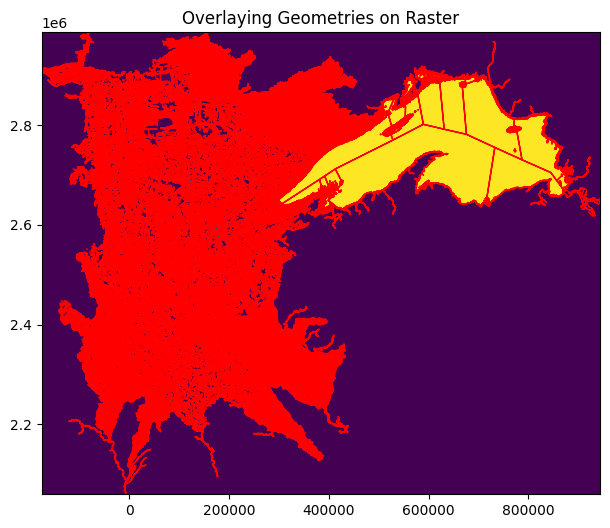

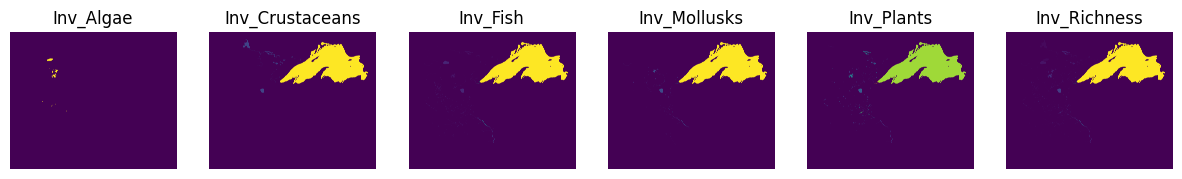

Raster file saved as 'my_data/MN_ch3/MN_ZM_inv_richness.tif' in CRS EPSG:5070 with band names: ['Inv_Algae', 'Inv_Crustaceans', 'Inv_Fish', 'Inv_Mollusks', 'Inv_Plants', 'Inv_Richness']


In [37]:
export_inv_richness(inv_rich_training, training_path + training_state_abbr + '_' + nas_name +'_inv_richness.tif')

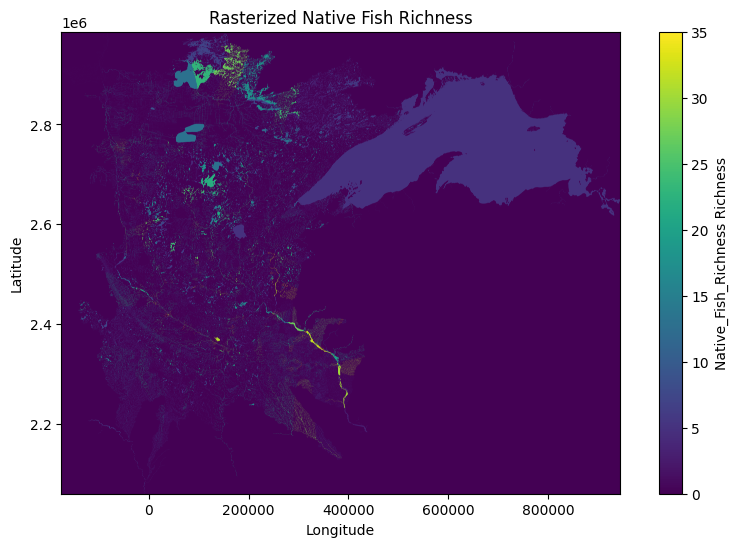

In [38]:
process_and_export_native_fish_raster(
    my_path=training_path, 
    my_crs="EPSG:5070",
    state_abbr=training_state_abbr
)

In [39]:
# Combine all the predictors you just created and export a final combined raster 
# Define input files
input_files_bio_training = [
    training_path + training_state_abbr +'_' + nas_name + "_inv_richness.tif", 
    training_path + training_state_abbr + "_Native_Fish_Richness.tif"]
#Combine rasters into a multi-band GeoTIFF
output_file_bio_training = training_path + training_state_abbr + '_' + nas_name + "_combined_bio.tif" # this will replace the other combined tif you made.
combine_geotiffs(input_files_bio_training, output_file_bio_training)

print(f"✅ Multi-band raster saved as {output_file_bio_training}")

✅ Multi-band raster saved as my_data/MN_ch3/MN_ZM_combined_bio.tif


In [ ]:
'''
Note these distance predictors are highly correlated. You should make the predictor that is most relevant to your taxa
or if your target does spread by both mechanisms make both and let the model sort it out. This is kind of nuanced as Road Distance may also
be informative of AIS which were originally stocked and now spread by stream/river network such as Rainbow and Brook Trout.
'''

# Road Distance

In [ ]:
#Import and format data for road network/distance analysis
my_roads, pos_endpoints, neg_endpoints, ramps_in_water_epoints, lakes_no_ramp_epoints = extract_roads_and_endpoints(
    local_path=training_path,
    state_abbr=training_state_abbr,
    state_fips=training_fip,
    state_name=training_state_abbr,
    buffered_water = buffered_water_training,
    nas_id=nas_id,
    my_crs=my_crs
)

In [ ]:
water_with_dist = compute_and_export_road_distances(
    my_roads=my_roads,
    pos_endpoints=pos_endpoints,
    neg_endpoints=neg_endpoints,
    ramps_epoints=ramps_in_water_epoints,
    lakes_epoints=lakes_no_ramp_epoints,
    buffered_water=buffered_water_training,
    my_crs=my_crs,
    my_path= training_path,
    my_state=training_state_abbr,
    nas_name= nas_name
)

# Stream/River Distance

In [ ]:
# Paths
stream_path = os.path.join(training_path, f"full_streams.shp")
presence_path = os.path.join(training_path, f"{training_state_abbr}_{nas_name}_pos_data.shp")
output_raster_fp = os.path.join(training_path, f"{training_state_abbr}_dist_to_src_river_{nas_name}.tif")
metadata_fp = output_raster_fp.replace('.tif', '_metadata.json')

In [ ]:
# 1. Prepare inputs
streams_all = prepare_stream_network(stream_path, simplify_tolerance=1000, crs=my_crs)
presence_all = prepare_presence_points(presence_path, crs=my_crs)

In [ ]:
# 2. Run Dijkstra model
run_stream_distance_model(training_state_abbr, streams_all, presence_all, training_path)

In [ ]:
# 3. Postprocess results
vertices_fp = os.path.join(training_path, f"{training_state_abbr}_vertex_distances.gpkg")
streams_fp = stream_path
water_fp = os.path.join(training_path, f"{training_state_abbr}_buffered_water.shp")
vertices, wb_conn, wb_disc, _ = postprocess_stream_network(vertices_fp, streams_fp, water_fp)

In [ ]:
# 4. Rasterize
raster_array = make_stream_distance_raster(vertices, wb_conn, wb_disc, output_raster_fp, metadata_fp, nas_name, pixel_size=100, state_abbr=training_state_abbr)

In [ ]:
# Combine all the predictors you just created and export a final combined raster 
# Define input files
input_files_dist_training = [
    training_path + training_state_abbr +'_road_distance_' + nas_name + ".tif", 
    training_path + training_state_abbr + '_dist_to_src_river_' + nas_name + '.tif',
    training_path + training_state_abbr + 'ais_explorer_data.tif']
#Combine rasters into a multi-band GeoTIFF
output_file_dist_training = training_path + training_state_abbr + '_' + nas_name + "_combined_dist.tif" # this will replace the other combined tif you made.
combine_geotiffs(input_files_dist_training, output_file_dist_training)

print(f"✅ Multi-band raster saved as {output_file_dist_training}")

In [5]:
# ***You need to run this GEE script for your state and homerange first***
# https://code.earthengine.google.com/b5d49bb675cc2d6583e866dc1dfb440b
#get taxon key for your AIS from gbif
#species.name_backbone(name='Dreissena polymorpha', kingdom='animal')
my_training_state = training_state_abbr # should be the postal code abbreviation for the state you created the environmental raster for....
my_nas_id = nas_id # go to USGS NAS database for species_ids (e.g., 5 = Zebra Mussels; 237 = Eurasian watermilfoil; 551 = Bighead carp)
my_path = training_path
homerange_raster = my_path + "homerange_2003_2022.tif"
invaded_raster = my_path + "inv_rsd_2003_2022.tif"
my_countries = ["RU", "UA", "BG", "RO", "GE", "AZ", "TM", "KZ"] # Endemic range countries for your taxa
my_taxon = 2287072  # gbif taxon id ; Eurasian watermilfoil = 2362486; Zebra mussels = 2362486
limit = 10000 # This is for the gbif function so you don't blow up your computer... Just kidding that shouldn't happen : )
my_scale = 1000 

In [6]:
# Functions
def gbif_api_call(taxon, country, limit):
    """Fetch GBIF occurrences for a given taxon and country."""
    URL_BASE = 'https://api.gbif.org/v1/'
    url_request = f"{URL_BASE}occurrence/search?taxonKey={taxon}&country={country}&limit={limit}"  
    response = requests.get(url_request, timeout=30)
    return response.json()  # Return the JSON response directly

def nas_api_call(nas_id, state):
    URL_BASE = 'http://nas.er.usgs.gov/api/v2/'
    url_request = f"{URL_BASE}/occurrence/search?species_ID={nas_id}&state={my_training_state}"
    response = requests.get(url_request, timeout=None).json()
    results = pd.json_normalize(response, 'results')
    return results


def sample_multiband_geotiff_with_names(raster_path, gdf):
    """
    Samples a multi-band GeoTIFF at specified point locations from a GeoDataFrame,
    using band names from the raster.

    Parameters:
    - raster_path (str): Path to the GeoTIFF file.
    - gdf (GeoDataFrame): GeoDataFrame containing point geometries.

    Returns:
    - GeoDataFrame with additional columns for each band, using raster band names.
    """

    # Open the raster file
    with rasterio.open(raster_path) as src:
        # Reproject GeoDataFrame to match raster CRS if needed
        if gdf.crs != src.crs:
            gdf = gdf.to_crs(src.crs)

        # Convert point geometries to raster pixel coordinates
        coords = [(geom.x, geom.y) for geom in gdf.geometry]

        # Sample raster at point locations (returns a list of tuples with values per band)
        sampled_values = list(src.sample(coords))

        # Get band names (if available, otherwise use default names)
        band_names = src.descriptions if all(src.descriptions) else [f"band_{i+1}" for i in range(src.count)]

        # Create new columns in the GeoDataFrame with the corresponding band names
        for band_idx, band_name in enumerate(band_names):
            gdf[band_name] = [val[band_idx] for val in sampled_values]

    return gdf

def filter_dataframe_columns(df, feature_choices):
    return df[[col for col in df.columns if col in feature_choices or col == "geometry"]]

def extract_fields(data):
    """Extract relevant fields from GBIF response."""
    extracted_data = []
    for record in data:
        entry = {
            'key': record.get('key'),
            'species': record.get('species'),
            'decimalLatitude': record.get('decimalLatitude'),
            'decimalLongitude': record.get('decimalLongitude'),
            'countryCode': record.get('countryCode'),
            'year': record.get('year')
        }
        extracted_data.append(entry)
    return extracted_data



In [7]:
gbif_result = []
for country in my_countries:
    result = gbif_api_call(my_taxon, country, limit)
    gbif_result.extend(result.get("results", []))  # Append results directly
# Extract fields from all collected results
homerange_points = pd.DataFrame(extract_fields(gbif_result))
homerange_points = gpd.GeoDataFrame(
    homerange_points, geometry=gpd.points_from_xy(homerange_points.decimalLongitude, homerange_points.decimalLatitude)).dropna().set_crs(4269).to_crs(5070)

In [42]:
pres_gdf = gpd.read_file(training_path + 'MN_ZM_pos_data.shp')

In [45]:
pres_gdf.crs

<Projected CRS: EPSG:5070>
Name: NAD83 / Conus Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - CONUS onshore - Alabama; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming.
- bounds: (-124.79, 24.41, -66.91, 49.38)
Coordinate Operation:
- name: Conus Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [43]:
bg_gdf = gpd.read_file(training_path + 'MN_ZM_bg_data.shp')

In [50]:
# ---- Load training presence + background points ----
# (assumes you already have them as GeoDataFrames with same CRS as raster)
# e.g. pres_gdf and bg_gdf
all_points = pd.concat([pres_gdf, bg_gdf], ignore_index=True)

# ---- Open invaded raster ----
raster_path = invaded_raster
with rasterio.open(raster_path) as src:
    points_proj = all_points.to_crs(src.crs)
    coords = [(geom.x, geom.y) for geom in points_proj.geometry]
    sampled_vals = list(src.sample(coords))

# ---- Convert sampled results into DataFrame ----
pred_data = pd.DataFrame(sampled_vals, columns=band_names)

# ---- Add geometry + IDs ----
my_pred_data = gpd.GeoDataFrame(
    pd.concat([all_points.reset_index(drop=True), pred_data], axis=1),
    geometry=all_points.geometry,
    crs=all_points.crs
)

# ---- Clean up NoData values ----
with rasterio.open(raster_path) as src:
    if src.nodata is not None:
        my_pred_data.replace(src.nodata, np.nan, inplace=True)

# ---- Check result ----
print(my_pred_data.info())
print(my_pred_data.head())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 8014 entries, 0 to 8013
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Present                8014 non-null   int64   
 1   geometry               8014 non-null   geometry
 2   ndvi_summer_max        8014 non-null   float32 
 3   total_precip_winter    8014 non-null   float32 
 4   total_precip_spring    8014 non-null   float32 
 5   total_precip_summer    8014 non-null   float32 
 6   total_precip_fall      8014 non-null   float32 
 7   Heat_Insolation_Load   8014 non-null   float32 
 8   Topographic_Diversity  8014 non-null   float32 
 9   gHM                    8002 non-null   float32 
 10  ndsi                   8014 non-null   float32 
 11  Flashiness             8014 non-null   float32 
 12  runoff                 8014 non-null   float32 
 13  drawdown               8014 non-null   float32 
 14  LST_annual_median      8014 non-

In [69]:
def MESS(ref_df, pred_df):
    # Extract geometry before dropping it
    geometry = None
    if "geometry" in pred_df.columns:
        geometry = pred_df["geometry"].copy()  # Save geometry separately
        pred_df = pred_df.drop(columns=["geometry"], errors="ignore")  # Drop before calculations

    # Ensure reference DataFrame does not include geometry
    ref_numeric = ref_df.drop(columns=["geometry"], errors="ignore")  # Avoid geometry errors

    # Compute min and max values for each variable
    mins = dict(ref_numeric.min())
    maxs = dict(ref_numeric.max())

    def calculate_s(column):
        values = ref_numeric[column]  # Reference values
        sims = []

        for element in np.array(pred_df[column]):
            f = np.count_nonzero((values < element)) / values.size

            if f == 0:
                sim = ((element - mins[column]) / (maxs[column] - mins[column]))
            elif 0 < f <= 50:
                sim = 2 * f
            elif 50 < f < 100:
                sim = 2 * (1 - f)
            elif f == 100:
                sim = ((maxs[column] - element) / (maxs[column] - mins[column]))

            sims.append(sim)

        return sims

    # Compute similarity scores for each predictor
    sim_df = pd.DataFrame()
    for c in pred_df.columns:
        sim_df[c] = calculate_s(c)

    # Compute MESS values
    min_similarity = sim_df.min(axis=1)  # Least similar predictor's score
    MoD = sim_df.idxmin(axis=1)  # Least similar predictor's name

    # Combine results
    MESS = pd.concat([min_similarity, MoD], axis=1)
    MESS.columns = ["MESS_Score", "Least_Similar_Variable"]

    # Reattach geometry if it was present
    if geometry is not None:
        print("Before reattaching geometry:", MESS.dtypes)  # Debug print
    
        MESS["geometry"] = geometry  # Re-add geometry
        MESS = gpd.GeoDataFrame(MESS, geometry="geometry", crs=5070)  # Convert back to GeoDataFrame
        
        print("After reattaching geometry:", MESS.dtypes)  # Debug print
        print("Geometry column exists?", "geometry" in MESS.columns)
    
    return MESS



In [70]:
feature_choices = ['ndvi_summer_max', 'total_precip_winter', 'total_precip_spring', 'total_precip_summer', 'total_precip_fall', 'Heat_Insolation_Load', 'Topographic_Diversity', 'gHM', 'ndsi', 'Flashiness', 'runoff', 
                   'drawdown', 'LST_annual_median', 'LST_summer_max', 'LST_winter_min', 'LST_spring_max', 'LST_fall_median', "geometry"]
ref_data = sample_multiband_geotiff_with_names(homerange_raster, homerange_points)
my_ref_data = filter_dataframe_columns(ref_data, feature_choices).dropna()
my_pred_data = filter_dataframe_columns(my_pred_data, feature_choices).dropna()

In [71]:
my_mess = MESS(my_ref_data, my_pred_data)
my_mess_clean = my_mess.dropna()


Before reattaching geometry: MESS_Score                float64
Least_Similar_Variable     object
dtype: object
After reattaching geometry: MESS_Score                 float64
Least_Similar_Variable      object
geometry                  geometry
dtype: object
Geometry column exists? True


In [73]:
my_mess_clean.crs

<Projected CRS: EPSG:5070>
Name: NAD83 / Conus Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - CONUS onshore - Alabama; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming.
- bounds: (-124.79, 24.41, -66.91, 49.38)
Coordinate Operation:
- name: Conus Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [74]:
def interpolate_mess(mess_points_gdf, out_raster_path, res=100, method="nearest", power=2):
    """
    Interpolate MESS scores from points to a raster grid.

    Parameters
    ----------
    mess_points_gdf : GeoDataFrame
        Must have columns 'geometry' (Point) and 'MESS'.
    out_raster_path : str
        Path to write GeoTIFF output.
    res : float
        Pixel resolution (map units).
    method : str
        Interpolation method: "nearest", "linear", "cubic", "idw", or "kriging".
    power : float
        Power parameter for IDW (default=2).
    """

    # ---- Extract coordinates and values ----
    x = mess_points_gdf.geometry.x.values
    y = mess_points_gdf.geometry.y.values
    z = mess_points_gdf["MESS_Score"].values

    # ---- Define raster grid ----
    xmin, ymin, xmax, ymax = mess_points_gdf.total_bounds
    width = int((xmax - xmin) / res)
    height = int((ymax - ymin) / res)

    grid_x = np.linspace(xmin, xmax, width)
    grid_y = np.linspace(ymin, ymax, height)
    grid_xx, grid_yy = np.meshgrid(grid_x, grid_y)

    if method == "kriging":
        # Ordinary Kriging with default variogram
        OK = OrdinaryKriging(
            x, y, z,
            variogram_model="spherical",  # options: "gaussian", "exponential", "linear"
            verbose=False,
            enable_plotting=False
        )
        arr, _ = OK.execute("grid", grid_x, grid_y)
        arr = np.flipud(arr.data)  # flip y-axis for raster orientation

    elif method == "idw":
        # Inverse Distance Weighting
        xi = grid_xx.flatten()
        yi = grid_yy.flatten()
        dist = np.sqrt((xi[:, None] - x[None, :])**2 + (yi[:, None] - y[None, :])**2)

        # Avoid divide by zero (set very small distance)
        dist[dist == 0] = 1e-10

        weights = 1 / (dist ** power)
        z_idw = np.sum(weights * z[None, :], axis=1) / np.sum(weights, axis=1)
        arr = z_idw.reshape(grid_xx.shape)

    else:
        # Scipy griddata interpolation (nearest, linear, cubic)
        arr = griddata(
            (x, y), z, (grid_xx, grid_yy),
            method=method
        )

    # ---- Raster transform ----
    transform = from_origin(xmin, ymax, res, res)

    # ---- Save as float32 raster ----
    with rasterio.open(
        out_raster_path,
        "w",
        driver="GTiff",
        height=arr.shape[0],
        width=arr.shape[1],
        count=1,
        dtype="float32",
        crs=mess_points_gdf.crs,
        transform=transform,
        nodata=np.nan
    ) as dst:
        dst.write(arr.astype("float32"), 1)

    print(f"✅ Saved {method} interpolated MESS raster: {out_raster_path}")


In [77]:
interpolate_mess(my_mess_clean, training_path + training_state_abbr + '_homerange_sim.tif', res=100,  method="nearest")

✅ Saved nearest interpolated MESS raster: my_data/MN_ch3/MN_homerange_sim.tif


In [ ]:
# Now upload all these predictor rasters to GEE